The relationship of multiple linear regression is defined as follows(relationship 1).

<img src='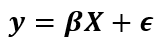
'>

The following relationship is used to find the parameters(relationship 2).

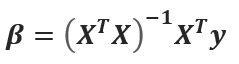

First, we load the sample dataset using Pandas.

In [11]:
import pandas as pd
brooks=pd.read_csv('BrooksData/brooks.csv')
brooks.head()

,Price,Living,quality,structure,renovation,condiction,greenspace,Traffic,VIEW,Time,X,Y
0,12.328290,0.148714,0.209074,0.25,0.5,0.333333,0.0,0.333333,0.336538,37951,439542.8867,5598242.529
1,12.534059,0.368753,0.164102,0.50,1.0,1.000000,0.0,0.666667,0.019231,37600,435349.9195,5609801.479
2,12.921470,0.314410,0.090522,0.75,1.0,0.333333,0.0,0.000000,0.028846,38135,436882.1112,5605366.512
3,12.089539,0.102426,0.119324,0.25,0.0,0.333333,0.0,0.000000,0.211538,37991,441028.8602,5598450.498
4,12.314927,0.238476,0.216503,0.25,0.0,1.000000,0.0,0.666667,0.096154,37854,434090.7299,5609800.138


We need to convert the x and y coordinates to longitude and latitude. Later, these coordinates are used to find the travel distance between the points of housing price data.

In [12]:
!pip install pyproj
from pyproj import CRS
crs_32612 = CRS("EPSG:32612")
from pyproj import Transformer
crs_4326 = CRS("WGS84")
transformer = Transformer.from_crs(crs_32612, crs_4326)
brooks['lat'],brooks['lon']=transformer.transform(brooks['X'],brooks['Y'])

Defaulting to user installation because normal site-packages is not writeable


We need to apply to the site and obtain the travel distance between the points of housing price data. The most distance matrix that this site can calculate is 50 by 50 matrix. Using these matrices, we can obtain the distance matrix of housing price data, which is the matrix of 999 by 999.

In [13]:
numbers=list(range(0, 999, 49))
numbers.append(999)
a=[]
for i in range(0,len(numbers)-1):
    url1='https://router.project-osrm.org/table/v1/driving/'
    cols=list(range(numbers[i],numbers[i+1]))
    for g in range(cols[0],cols[-1]):
        url1+=str(g)+','+str(g)+';'
    url1+=str(cols[-1])+','+str(cols[-1])+';'
    for j in range(0,len(numbers)-1):
        url2=url1
        rows=list(range(numbers[j],numbers[j+1]))
        for h in range(rows[0],rows[-1]):
            url2+=str(h)+','+str(h)+';'
        url2+=str(rows[-1])+','+str(rows[-1])
        url2+='?annotations=distance'
        a.append(url2)
        
b=[]
for i in range(0,len(numbers)-1):
    url1='https://router.project-osrm.org/table/v1/driving/'
    cols=list(range(numbers[i],numbers[i+1]))
    for g in range(cols[0],cols[-1]):
        url1+=str(brooks['lon'][g])+','+str(brooks['lat'][g])+';'
    url1+=str(brooks['lon'][cols[-1]])+','+str(brooks['lat'][cols[-1]])+';'
    for j in range(0,len(numbers)-1):
        url2=url1
        rows=list(range(numbers[j],numbers[j+1]))
        for h in range(rows[0],rows[-1]):
            url2+=str(brooks['lon'][h])+','+str(brooks['lat'][h])+';'
        url2+=str(brooks['lon'][rows[-1]])+','+str(brooks['lat'][rows[-1]])
        url2+='?annotations=distance'
        b.append(url2)

Now, we need to obtain the 50 by 50 interval matrices.

In [ ]:
import warnings
import requests
warnings.filterwarnings("ignore")
jsons=[]
missed_requests=[]
missed_indexes=[]
for k in range(0,len(b)):
    our_request=requests.get(b[k], verify = False)
    try:
        our_json=our_request.json()
        start='https://router.project-osrm.org/table/v1/driving/'
        end='?annotations=distance'
        index_of_locations=(a[k].split(start))[1].split(end)[0].split(';')
        indexes=[]
        for f in range(0,len(index_of_locations)):
            indexes.append(index_of_locations[f].split(','))
        int_indexes=[]
        for e in range(0,len(indexes)):
            int_indexes.append(int(indexes[e][0]))
        for d in range(0,len(int_indexes)):
            our_json['sources'][d]['location']=[brooks['lon'][int_indexes[d]],\
                                                brooks['lat'][int_indexes[d]]]
        jsons.append(our_json)
    except:
        missed_requests.append(b[k])
        missed_indexes.append(k)

We check whether the number of
missed_requests
is it equal to zero or not?

In [7]:
len(missed_requests)

0

If it's not equal to zero, the following code should also be run to make sure you've received all the requests. This will continue until there are no distances left. Previously, these requests were introduced as missed_requests and here they are introduced as j_requests.

In [8]:
j_requests=[]
j_indexes=[]
for k in range(0,len(missed_indexes)):
    try:
        our_request=requests.get(b[missed_indexes[k]], verify = False)
        our_json=our_request.json()
        start='https://router.project-osrm.org/table/v1/driving/'
        end='?annotations=distance'
        index_of_locations=(a[missed_indexes[k]].split(start))[1].split(end)[0].split(';')
        indexes=[]
        for f in range(0,len(index_of_locations)):
            indexes.append(index_of_locations[f].split(','))
        int_indexes=[]
        for e in range(0,len(indexes)):
            int_indexes.append(int(indexes[e][0]))
        for d in range(0,len(int_indexes)):
            our_json['sources'][d]['location']=[brooks['lon'][int_indexes[d]],\
                                                brooks['lat'][int_indexes[d]]]
        jsons_1.append(our_json)
    except:
        j_requests.append(b[missed_indexes[k]])
        j_indexes.append(missed_indexes[k])

So that we don't have to reapply the code next time, we put JSONS in a file with a dill extension and store it physically on our computer's hard drive.

In [14]:
import pickle
with open('jsons.pkl', 'wb') as file:
    pickle.dump(jsons, file)

The next time to run the codes; first we load pkl and and there is no need to re-get the requests.

In [15]:
import pickle
with open('jsons.pkl', 'rb') as file:
    jsons = pickle.load(file)

Now we extract the value of the travel distance between points in each of the 50 by 50 distance matrices and store them in a list.

In [16]:
dises=[]
for h in range(0,len(jsons)):
    a1=jsons[h]
    for i in range(0,len(a1['distances'])):
        for j in range(0,len(a1['distances'][i])):
            dises.append([a1['sources'][i]['location'][0],
 a1['sources'][i]['location'][1],
 a1['sources'][j]['location'][0],
 a1['sources'][j]['location'][1],
 a1['distances'][i][j]])

Now, using the code below, we will remove the duplicate values. In fact, the values in which both the beginning and the end of the journey and the distance of the journey are the same are eliminated.

In [17]:
import itertools
dises.sort()
dises=list(dises for dises,_ in itertools.groupby(dises))

Now the intervals in dises is in the form of a list of lists, in each list there are the starting and ending points and the travel distance related to the two points. Now we want to have a list of lists, each list is a list of lists in which the distance of travel between one point and the rest of the points has been calculated.

In [ ]:
values =set(map(lambda x:(x[0],x[1]), dises))
list_dises = [[y for y in dises if (y[0],y[1])==x] for x in values]

According to the code below, we have 995 distinct points.

In [ ]:
len(set(tuple(row) for row in [(j, k) for j,k in zip(brooks['lon'],brooks['lat'])]))

So in
list_dises
each list should contain 995 lists. Because in each list, the distance between each point and the rest of the points and itself has been calculated. If we had a list that had more than 995 lists, we should find the duplicate point and delete it. In these cases, only the endpoint is duplicate and the travel distance is different, otherwise it would have been eliminated in the previous stages. The distance is different because the distance between two points may be obtained at different times of the day and night according to the volume of traffic.

In [14]:
revision_list_dises=[]   
for i in range(0,len(list_dises)):
    tmp_revision=[]
    current_revision=list_dises[i]
    current_list_dises=[]
    for j in range(0,len(current_revision)):
        if [current_revision[j][2],current_revision[j][3]] not in tmp_revision:
            current_list_dises.append(current_revision[j])
            tmp_revision.append([current_revision[j][2],current_revision[j][3]])
    revision_list_dises.append(current_list_dises)

Now, we will make the distance between each point and the rest of the points and itself, which was saved in a list of lists in the previous step, into a dictionary of dictionaries. By doing this, each dictionary is assigned to a point in which there is another dictionary in which the distance between that point and the rest of the points and itself has been calculated. The purpose of this is to create a dataframe using a dictionary of dictionaries.

In [16]:
dictionary_of_distances={}
for i in range(0,len(revision_list_dises)):
    tmp_revision_list_dis=revision_list_dises[i]
    dictionary_of_distances[str(tmp_revision_list_dis[0][0])+','+str(tmp_revision_list_dis[0][1])]={}
    for j in range(0,len(tmp_revision_list_dis)):
        if tmp_revision_list_dis[j][4]==0:
            if [tmp_revision_list_dis[j][0],tmp_revision_list_dis[j][1]]!=[tmp_revision_list_dis[j][2],\
                                                                           tmp_revision_list_dis[j][3]]:
                dictionary_of_distances[str(tmp_revision_list_dis[j][0])+','+str(tmp_revision_list_dis[j][1])]\
                [str(tmp_revision_list_dis[j][2])+','+str(tmp_revision_list_dis[j][3])]=abs(tmp_revision_list_dis[j][4])+0.1
            else:
                dictionary_of_distances[str(tmp_revision_list_dis[j][0])+','+str(tmp_revision_list_dis[j][1])]\
                [str(tmp_revision_list_dis[j][2])+','+str(tmp_revision_list_dis[j][3])]=abs(tmp_revision_list_dis[j][4])
        else:
            dictionary_of_distances[str(tmp_revision_list_dis[j][0])+','+str(tmp_revision_list_dis[j][1])]\
            [str(tmp_revision_list_dis[j][2])+','+str(tmp_revision_list_dis[j][3])]=abs(tmp_revision_list_dis[j][4])

Since the distance between point 1 and 2 is different from the distance between point 2 and 1, because different routes are used in the transportation network to travel from each of these points to another point. Therefore, in order to use a single distance between two points, we calculate the average distances between each pair of points and form the dataframe corresponding to the distance matrix.

In [20]:
keys=list(dictionary_of_distances.keys())
for i in range(0,len(keys)):
    for j in range(0,len(keys)):
        first=dictionary_of_distances[keys[i]][keys[j]]
        second=dictionary_of_distances[keys[j]][keys[i]]
        result=(first+second)/2
        dictionary_of_distances[keys[i]][keys[j]]=result
        dictionary_of_distances[keys[j]][keys[i]]=result
dataframe_of_distances = pd.DataFrame.from_dict(dictionary_of_distances)

Finally, we store the obtained distance matrix physically on our computer's hard drive.

In [41]:
import pickle
with open('dataframe_of_distances.pkl', 'wb') as file:
    pickle.dump(dataframe_of_distances, file)

You can see the resulting distance matrix.

In [33]:
dataframe_of_distances.head()

,"-111.9800193902779,50.641824764437544","-111.80455741352041,50.49342070510727","-111.85589484778207,50.60748757938547","-111.97626593276009,50.62555851190002","-111.92886050672124,50.64076793417325","-111.92866550850727,50.629581307371346","-111.8916298561183,50.606747082933246","-111.81077980051134,50.48547035359942","-111.7987633419414,50.492400477339416","-111.93712352470823,50.5864586424768",...,"-111.95035522358194,50.6255379093181","-111.94706632897206,50.62098964280719","-111.9469131670666,50.63831916692557","-111.91843505379539,50.610466639766074","-111.88513671708418,50.58524808557249","-111.8585189791055,50.62848935301355","-111.9706254566445,50.61858160891099","-111.93448454418602,50.58619201152526","-111.88129569127145,50.628919484529895","-111.81166230542398,50.47805574752547"
"-111.98997352370635,50.6074778278768",5684.2,32832.55,21422.9,6703.1,11036.55,9641.45,15392.90,33273.85,32421.15,4931.2,...,10660.95,10154.85,9473.55,10945.25,16814.80,20771.75,9257.4,4961.2,19647.15,33336.05
"-111.98986337203984,50.60567539541235",5692.5,32840.80,21431.2,6711.4,11044.85,9649.75,15401.15,33282.15,32429.45,4922.9,...,10669.25,10163.10,9481.85,10953.50,16823.05,20780.05,9265.7,4952.9,19655.45,33344.35
"-111.98985755118872,50.60627471812511",5692.7,32841.05,21431.4,6711.6,11045.05,9649.95,15401.40,33282.35,32429.65,4922.7,...,10669.45,10163.30,9482.05,10953.75,16823.25,20780.25,9265.9,4952.7,19655.65,33344.55
"-111.98980116467344,50.60545672854696",5696.9,32845.20,21435.6,6715.8,11049.25,9654.15,15405.55,33286.55,32433.80,4918.5,...,10673.65,10167.50,9486.25,10957.90,16827.40,20784.45,9270.1,4948.5,19659.85,33348.75
"-111.98972121316767,50.60543898042324",5702.6,32850.85,21441.2,6721.4,11054.95,9659.75,15411.25,33292.20,32439.45,4912.8,...,10679.30,10173.15,9491.85,10963.55,16833.10,20790.05,9275.7,4942.9,19665.45,33354.35


In the next time, we just need to load the dataframe and there is no need to repeat the previous steps.

In [21]:
import pickle
with open('dataframe_of_distances.pkl', 'rb') as file:
    dataframe_of_distances = pickle.load(file)

We obtain standardized independent and dependent variables in each of the training and testing sets, as well as the coordinates of longitude and latitude associated with each of these sets.

In [23]:
!pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
x_train, x_test, y_train, y_test = train_test_split(
    brooks.drop(['Price'],axis=1).values,
    preprocessing.minmax_scale(brooks['Price'].values.reshape(-1, 1)),test_size=0.3, random_state=100)
x_train=pd.DataFrame(x_train,columns=['Living','quality','structure','renovation','condiction','greenspace','Traffic',
                                      'VIEW','Time','X','Y','lon','lat'])
x_test=pd.DataFrame(x_test,columns=['Living','quality','structure','renovation','condiction','greenspace','Traffic',
                                      'VIEW','Time','X','Y','lon','lat'])
x_coord_train=x_train['X'].ravel().reshape(-1,1)
y_coord_train=x_train['Y'].ravel().reshape(-1,1)
lon_train=x_train['lon'].ravel().reshape(-1,1)
lat_train=x_train['lat'].ravel().reshape(-1,1)
time_train=x_train['Time'].ravel().reshape(-1,1)
x_coord_test=x_test['X'].ravel().reshape(-1,1)
y_coord_test=x_test['Y'].ravel().reshape(-1,1)
lon_test=x_test['lon'].ravel().reshape(-1,1)
lat_test=x_test['lat'].ravel().reshape(-1,1)
time_test=x_test['Time'].ravel().reshape(-1,1)
x_train=preprocessing.minmax_scale(x_train.drop(['Time','X','Y','lon','lat'],axis=1))
x_test=preprocessing.minmax_scale(x_test.drop(['Time','X','Y','lon','lat'],axis=1))

Defaulting to user installation because normal site-packages is not writeable


Now we obtain the geographic distance matrix for each of the training and testing sets individually. These matrices are used in the training and evaluation of adaptive kernels.

In [35]:
import math
distances=[]
for i in range(0,len(x_coord_train)):
    dises=[]
    for j in range(0,len(x_coord_train)):
        diff_x=x_coord_train[i]-x_coord_train[j]
        diff_y=y_coord_train[i]-y_coord_train[j]
        dis=math.sqrt((diff_x**2)+(diff_y**2))
        dises.append(dis)
    distances.append(dises)
strings=[]
for i in range(0,len(x_coord_train)):
    strings.append(str(round(x_coord_train[i][0],8))+','+str(round(y_coord_train[i][0],8)))
df_euclidean_distances_train = pd.DataFrame(distances, columns=strings, index=strings)
distances=[]
for i in range(0,len(x_coord_test)):
    dises=[]
    for j in range(0,len(x_coord_train)):
        diff_x=x_coord_test[i]-x_coord_train[j]
        diff_y=y_coord_test[i]-y_coord_train[j]
        dis=math.sqrt((diff_x**2)+(diff_y**2))
        dises.append(dis)
    distances.append(dises)
indexes=[]
for i in range(0,len(x_coord_test)):
    indexes.append(str(round(x_coord_test[i][0],8))+','+str(round(y_coord_test[i][0],8)))
cols=[]
for i in range(0,len(x_coord_train)):
    cols.append(str(round(x_coord_train[i][0],8))+','+str(round(y_coord_train[i][0],8)))
df_euclidean_distances_test = pd.DataFrame(distances, columns=cols, index=indexes)

We do the same for the travel distance matrix and divide it into two matrices: training and testing. The names of columns and indexes in the dataframe consist of a combination of latitude and longitude up to 8 decimal places.

In [36]:
cols = dataframe_of_distances.columns
for col in cols:
    lon=round(float(col.split(',')[0]),8)
    lat=round(float(col.split(',')[1]),8)
    col_name=str(lon)+','+str(lat)
    dataframe_of_distances.rename(columns={col:col_name}, inplace =True)
indices = dataframe_of_distances.index
for idx in indices:
    lon=round(float(idx.split(',')[0]),8)
    lat=round(float(idx.split(',')[1]),8)
    idx_name=str(lon)+','+str(lat)
    dataframe_of_distances.rename(index={idx:idx_name}, inplace =True)
trains=[]
for i in range(0,len(lon_train)):
    trains.append(str(round(lat_train[i][0],8))+','+str(round(lon_train[i][0],8)))
df_train_travel_distances = dataframe_of_distances[trains]
df_train_travel_distances = df_train_travel_distances.loc[trains]
tests=[]
for i in range(0,len(lon_test)):
    tests.append(str(round(lat_test[i][0],8))+','+str(round(lon_test[i][0],8)))
df_test_travel_distances = dataframe_of_distances[trains]
df_test_travel_distances = df_test_travel_distances.loc[tests]

Finally, we also form the time distance matrix.

In [37]:
distances=[]
for i in range(0,len(time_train)):
    dises=[]
    for j in range(0,len(time_train)):
        dis=abs(time_train[i][0]-time_train[j][0])
        dises.append(dis)
    distances.append(dises)
strings=[]
for i in range(0,len(time_train)):
    strings.append(str(time_train[i][0]))
df_times_train = pd.DataFrame(distances, columns=strings, index=strings)
distances=[]
for i in range(0,len(time_test)):
    dises=[]
    for j in range(0,len(time_train)):
        dis=abs(time_test[i][0]-time_train[j][0])
        dises.append(dis)
    distances.append(dises)
indexes=[]
for i in range(0,len(time_test)):
    indexes.append(str(time_test[i][0]))
cols=[]
for i in range(0,len(time_train)):
    cols.append(str(time_train[i][0]))
df_times_test = pd.DataFrame(distances, columns=cols, index=indexes)

You can see the matrix of independent variables of the training set.

In [69]:
import numpy as np
headers = ['Living','quality','structure','renovation','condiction','greenspace','Traffic','VIEW']
table=pd.DataFrame(x_train,columns=headers) 
table.head()

,Living,quality,structure,renovation,condiction,greenspace,Traffic,VIEW
0,0.275720,0.218964,0.50,0.166667,1.000000,0.4,0.0,0.053192
1,0.313100,0.126826,0.25,1.000000,1.000000,0.0,0.0,0.031915
2,0.334019,0.150300,0.50,1.000000,1.000000,0.0,0.0,0.021277
3,0.336420,0.318127,0.50,1.000000,1.000000,0.0,1.0,0.031915
4,0.080932,0.090033,0.25,0.500000,0.333333,0.0,0.0,0.042554


Using the numpy, we add the y-intercept to the above matrix.

In [70]:
ones_train=np.ones(shape=x_train.shape[0]).reshape(-1,1)
x_train=np.concatenate((ones_train,x_train),1)

The final matrix of independent variables in the training set will be as follows.

In [71]:
headers = ['Intercept','Living','quality','structure','renovation','condiction','greenspace','Traffic','VIEW']
table=pd.DataFrame(x_train,columns=headers) 
table.head()

,Intercept,Living,quality,structure,renovation,condiction,greenspace,Traffic,VIEW
0,1.0,0.275720,0.218964,0.50,0.166667,1.000000,0.4,0.0,0.053192
1,1.0,0.313100,0.126826,0.25,1.000000,1.000000,0.0,0.0,0.031915
2,1.0,0.334019,0.150300,0.50,1.000000,1.000000,0.0,0.0,0.021277
3,1.0,0.336420,0.318127,0.50,1.000000,1.000000,0.0,1.0,0.031915
4,1.0,0.080932,0.090033,0.25,0.500000,0.333333,0.0,0.0,0.042554


We do the same for test data.

In [41]:
ones_test=np.ones(shape=x_test.shape[0]).reshape(-1,1)
x_test=np.concatenate((ones_test,x_test),1)

Now we need to obtain the parameters using relationship 2.

In [42]:
params=np.linalg.inv(x_train.transpose().dot(x_train)).dot(x_train.transpose()).dot(y_train)

You can see the obtained parameters.

In [43]:
#!pip install tabulate
from tabulate import tabulate
m = np.array([[item for sublist in params.tolist() for item in sublist],
              ['Intercept','Living','quality','structure','renovation','condiction','greenspace','Traffic','VIEW']])
headers = ["param", "value"]

# Generate the table in fancy format.
table = tabulate(m.transpose(), headers, tablefmt="fancy_grid")

# Show it.
print(table)

╒════════════╤════════════╕
│      param │ value      │
╞════════════╪════════════╡
│  0.103482  │ Intercept  │
├────────────┼────────────┤
│  0.379694  │ Living     │
├────────────┼────────────┤
│  0.133689  │ quality    │
├────────────┼────────────┤
│  0.376858  │ structure  │
├────────────┼────────────┤
│ -0.0441764 │ renovation │
├────────────┼────────────┤
│  0.0244632 │ condiction │
├────────────┼────────────┤
│  0.010614  │ greenspace │
├────────────┼────────────┤
│ -0.0360452 │ Traffic    │
├────────────┼────────────┤
│  0.131379  │ VIEW       │
╘════════════╧════════════╛


So far we have finished training the data, now we need to evaluate the method, so we need to get the predictive values of the test data using the relationship 1.

In [44]:
predicts=[]
for i in range(0,len(x_test)):
    prediction=params.T.dot(x_test[i].T)
    predicts.append(prediction)

Now we need to obtain the accuracy of the desired method using the coefficient of determination, the coefficient of determination function is defined as follows.

In [45]:
def r_squared(y, y_hat):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

The value of the coefficient of determination is equal to

In [46]:
print(r_squared(y_test, predicts))

0.661273637529638


Reference of the above content
https://towardsdatascience.com/multiple-linear-regression-from-scratch-in-numpy-36a3e8ac8014

The geographically weighted regression method is defined as multiple linear regression, with the difference that the parameters are obtained from the following relation(relationship 3):

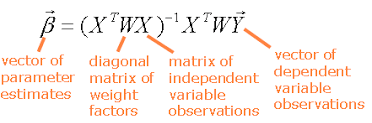

In relationship 3, matrix w is a diagonal matrix in which the elements outside the main diameter are equal to zero and the principal diameter elements are weighted to each observation to estimate the ith point
(relationship 4)

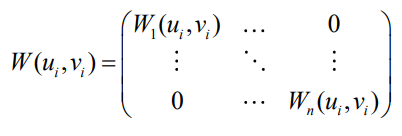

To define the weight matrix, the type of core and its function must be determined. In the fixed core, the spatial bandwidth is fixed and the weight of the observations that are placed in the considered bandwidth is determined based on their distance from the reference point, so the farther points are given less weight and the closer points are given more weight. This is well illustrated in the figure corresponding to the fixed core. The curves of this figure also represent the weighting functions of the observations around the reference point, but if the distribution of observations is not the same throughout the study area, it is likely that less information will be used for some points and in fact fewer points will be placed in the intended bandwidth and eventually fewer points will be used to estimate the reference point. To overcome this problem, the adaptive core is used. In this method, the bandwidth is determined based on the density of observations around the reference point, so that for each reference point, the number of observations is constant. Thus, in a fixed core, the bandwidth is constant but the number of observation points is different to estimate each reference point. In the adaptive core, the bandwidth is variable but the number of observation points is constant to estimate the reference point(figure 1).

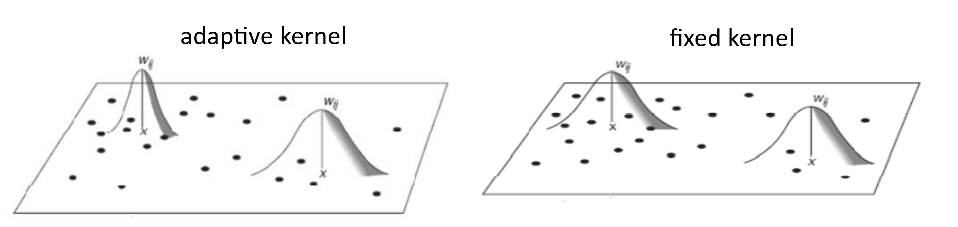

The weight assigned to each observation to estimate the reference point in each of the fixed and adaptive cores is obtained from the table below.
(Table 1)

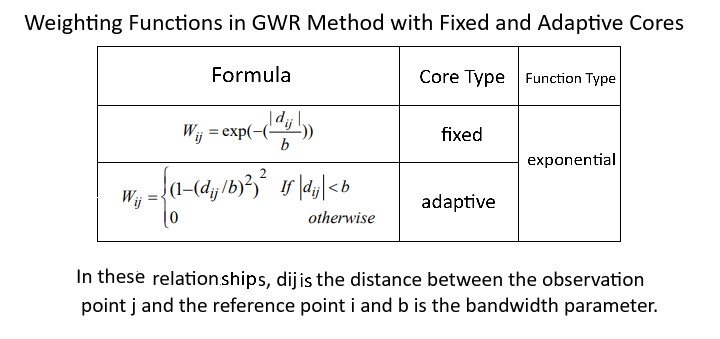

Now we will implement the geographical weighted regression method. This method has a parameter called spatial bandwidth that needs to be obtained. This parameter obtain from the cross-validation method. There are different types of methods that we can use here. We use leave one out cross validation method. In this method the training set is divided into two parts: training and validation.The training set includes all the training data except one item that is used in the validation set. Using the training set, we predict the y value of the validation set. This will lead to the first round of the validation process. In the next round, the item that was in the validation set in the previous round will be used in the training set and another item from the training set will be used in the validation set. Using the training set, we predict the y value of the validation set. Thus, the second round of the validation process is also completed. This process continues until all the training points are used once as an unknown point in the validation set and their y value is predicted based on the training set. In each of the rounds of the validation process, an error is obtained, and the error obtained from all rounds is obtained using the residual sum of squares method. Throughout this process, we use a spatial bandwidth. So again we use the cross-validation process for the another bandwidth and get the residual sum of squares obtained. Assuming that the spatial bandwidth of the first process is equal to 50 and the residual sum of its squares is equal to 20, and also in the second process, the spatial bandwidth is equal to 100 and the residual sum of its squares is equal to 10. The spatial bandwidth of the second process is selected. Again, we do a cross-validation process, and this time the spatial bandwidth is nominated for 150, because in the previous process, we saw that as the spatial bandwidth increases, the residual sum of squares decreases. If the residual sum of squares decreases this time, we will increase the spatial bandwidth again, and we will do this until the residual sum of squares is greater than the previous process in one of the cross-validation processes.

Reference of the above content
https://uk.sagepub.com/en-gb/eur/gis-algorithms/book241284 Chapter Eight

First, we will implement the geographically weighted regression method with a fixed core and euclidean distance. Therefore, we first do the training phase, which involves the use of the cross-validation method.

In [47]:
from sklearn.metrics import r2_score
import math
predictions_of_euclidean_fixed_gwr_for_train=[]
geographic_bandwidth_for_euclidean_fixed_gwr=800
for k in range(0,len(x_train)):
    current_coords=[x_coord_train[k][0],y_coord_train[k][0]]
    x_train_of_cv=np.asarray(x_train[0:k].tolist()+x_train[k+1::].tolist())
    y_train_of_cv=np.asarray(y_train[0:k].tolist()+y_train[k+1::].tolist())
    x_coords_train_of_cv=np.asarray(x_coord_train[0:k].tolist()+x_coord_train[k+1::].tolist())
    y_coords_train_of_cv=np.asarray(y_coord_train[0:k].tolist()+y_coord_train[k+1::].tolist())
    n = len(x_train_of_cv)
    weights=[]
    for i in range(0,n):
        diff_geographic=[current_coords[0]-x_coords_train_of_cv[i][0],current_coords[1]-y_coords_train_of_cv[i][0]]
        dis_geographic=math.sqrt(diff_geographic[0]**2+diff_geographic[1]**2)
        weight_geographic=math.exp((-1)*(dis_geographic/geographic_bandwidth_for_euclidean_fixed_gwr))
        weights.append(weight_geographic)
    matrix=np.array(weights)
    matrix=np.diag(matrix)
    elem1=np.linalg.inv((x_train_of_cv.T).dot(matrix).dot(x_train_of_cv))
    elem2=(x_train_of_cv.T).dot(matrix).dot(y_train_of_cv)
    beta=(elem1).dot(elem2)
    predict=beta.T.dot(np.array(x_train[k]).T)
    predictions_of_euclidean_fixed_gwr_for_train.append(predict.tolist()[0])
    
print('r2 score euclidean fixed GWR for train',r2_score(y_train, predictions_of_euclidean_fixed_gwr_for_train))

r2 score euclidean fixed GWR for train 0.8195815275858459


Now, we need to evaluate the test data using the parameter obtained from the previous step.

In [20]:
predictions_of_euclidean_fixed_gwr_for_test=[]
for k in range(0,len(x_test)):
    current_coords=[x_coord_test[k][0],y_coord_test[k][0]]
    n = len(x_train)
    weights=[]
    for i in range(0,n):
        diff_geographic=[current_coords[0]-x_coord_train[i][0],current_coords[1]-y_coord_train[i][0]]
        dis_geographic=math.sqrt(diff_geographic[0]**2+diff_geographic[1]**2)
        weight_geographic=math.exp((-1)*(dis_geographic/geographic_bandwidth_for_euclidean_fixed_gwr))
        weights.append(weight_geographic)
    matrix=np.array(weights)
    matrix=np.diag(matrix)            
    elem1=np.linalg.inv((x_train.T).dot(matrix).dot(x_train))
    elem2=(x_train.T).dot(matrix).dot(y_train)
    beta=(elem1).dot(elem2)
    predict=beta.T.dot(np.array(x_test[k]).T)
    predictions_of_euclidean_fixed_gwr_for_test.append(predict)

print('r2 score euclidean fixed GWR for test',r2_score(y_test, predictions_of_euclidean_fixed_gwr_for_test))

r2 score euclidean fixed GWR for test 0.7616172920861946


The spatiotemporal weighted regression method is defined as the geographical weighted regression method, with the difference that the weight of each observation for estimating the reference point includes the time weight in addition to the geographical weight. Time weight is also defined as spatial weight, except that instead of spatial bandwidth, we have time bandwidth. Therefore, in addition to spatial bandwidth, temporal bandwidth must also be adjusted. The spatial bandwidth obtained from the previous step is also used here, so only the temporal bandwidth needs to be adjusted. The final weight assigned to each observation is obtained from the product of spatial weight and temporal weight. You will see the training step of the spatiotemporally Weighted Regression Method with a fixed core and Euclidean distance.

In [21]:
time_bandwidth_for_euclidean_fixed_gtwr=300
predictions_of_euclidean_fixed_gtwr_for_train=[]
for k in range(0,len(x_train)):
    current_coords=[x_coord_train[k][0],y_coord_train[k][0]]
    current_time=time_train[k]
    x_train_of_cv=np.asarray(x_train[0:k].tolist()+x_train[k+1::].tolist())
    y_train_of_cv=np.asarray(y_train[0:k].tolist()+y_train[k+1::].tolist())
    x_coords_train_of_cv=np.asarray(x_coord_train[0:k].tolist()+x_coord_train[k+1::].tolist())
    y_coords_train_of_cv=np.asarray(y_coord_train[0:k].tolist()+y_coord_train[k+1::].tolist())
    time_train_of_cv=np.asarray(time_train[0:k].tolist()+time_train[k+1::].tolist())
    n = len(x_train_of_cv)
    weights=[]
    for i in range(0,n):
        diff_geographic=[current_coords[0]-x_coords_train_of_cv[i][0],current_coords[1]-y_coords_train_of_cv[i][0]]
        dis_geographic=math.sqrt(diff_geographic[0]**2+diff_geographic[1]**2)
        weight_geographic=math.exp((-1)*(dis_geographic/geographic_bandwidth_for_euclidean_fixed_gwr))
        dis_time=np.abs(current_time-time_train_of_cv[i])
        weight_time=math.exp((-1)*(dis_time/time_bandwidth_for_euclidean_fixed_gtwr))
        weights.append(weight_geographic*weight_time)
    matrix=np.array(weights)
    matrix=np.diag(matrix)
    elem1=np.linalg.inv((x_train_of_cv.T).dot(matrix).dot(x_train_of_cv))
    elem2=(x_train_of_cv.T).dot(matrix).dot(y_train_of_cv)
    beta=(elem1).dot(elem2)
    predict=beta.T.dot(np.array(x_train[k]).T)
    predictions_of_euclidean_fixed_gtwr_for_train.append(predict.tolist()[0])
    
print('r2 score euclidean fixed GTWR for train',r2_score(y_train, predictions_of_euclidean_fixed_gtwr_for_train))

r2 score euclidean fixed GTWR for train 0.8267168488799708


Now, we need to evaluate the spatiotemporal weighted regression method with a constant core and Euclidean distance using the test data.

In [22]:
predictions_of_euclidean_fixed_gtwr_for_test=[]
for k in range(0,len(x_test)):
    current_coords=[x_coord_test[k][0],y_coord_test[k][0]]
    current_time=time_test[k]
    n = len(x_train)
    weights=[]
    for i in range(0,n):
        diff_geographic=[current_coords[0]-x_coord_train[i][0],current_coords[1]-y_coord_train[i][0]]
        dis_geographic=math.sqrt(diff_geographic[0]**2+diff_geographic[1]**2)
        weight_geographic=math.exp((-1)*(dis_geographic/geographic_bandwidth_for_euclidean_fixed_gwr))
        dis_time=np.abs(current_time-time_train[i])
        weight_time=math.exp((-1)*(dis_time/time_bandwidth_for_euclidean_fixed_gtwr))
        weights.append(weight_geographic*weight_time)
    matrix=np.array(weights)
    matrix=np.diag(matrix)            
    elem1=np.linalg.inv((x_train.T).dot(matrix).dot(x_train))
    elem2=(x_train.T).dot(matrix).dot(y_train)
    beta=(elem1).dot(elem2)
    predict=beta.T.dot(np.array(x_test[k]).T)
    predictions_of_euclidean_fixed_gtwr_for_test.append(predict)

print('r2 score euclidean fixed GTWR for test',r2_score(y_test, predictions_of_euclidean_fixed_gtwr_for_test))

r2 score euclidean fixed GTWR for test 0.7533142422646272


In the geographical weighted regression method with an adaptive core, the training data are first sorted based on their distance from the validation point. For example, if we consider the number of 70 neighboring points to predict the validation point, then the distance of the 70th training point from the validation point is introduced as the spatial bandwidth. Then, to obtain the weight of each training point in estimating the validation point, if the distance of that training point is less than the validation point, we use the formula in Table 1, otherwise the weight of that point will be equal to zero. Now we will train the method of geographical weighted regression with adaptive core and Euclidean distance.

In [23]:
predictions_of_euclidean_adaptive_gwr_for_train=[]
n_neighbours_of_euclidean_adaptive_gwr_for_geographic=110
for k in range(0,len(x_train)):
    current_coords=[x_coord_train[k][0],y_coord_train[k][0]]
    desired_index=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
    current_geographic_distances=df_euclidean_distances_train[desired_index].values.tolist()
    current_geographic_distances.sort()
    neighbours=current_geographic_distances[1:n_neighbours_of_euclidean_adaptive_gwr_for_geographic+1]
    geographic_bandwidth=neighbours[-1]
    if type(geographic_bandwidth)==list:
        geographic_bandwidth=geographic_bandwidth[0]
    train_x_of_cv=np.asarray(x_train[0:k].tolist()+x_train[k+1::].tolist())
    train_y_of_cv=np.asarray(y_train[0:k].tolist()+y_train[k+1::].tolist())
    train_xcoords_of_cv=np.asarray(x_coord_train[0:k].tolist()+x_coord_train[k+1::].tolist())
    train_ycoords_of_cv=np.asarray(y_coord_train[0:k].tolist()+y_coord_train[k+1::].tolist())
    n = len(train_x_of_cv)
    weights=[]
    for i in range(0,n):
        diff_geographic=[current_coords[0]-train_xcoords_of_cv[i][0],current_coords[1]-train_ycoords_of_cv[i][0]]
        dis_geographic=math.sqrt(diff_geographic[0]**2+diff_geographic[1]**2)
        if dis_geographic<=geographic_bandwidth:
            weight_geographic=(1-(dis_geographic/geographic_bandwidth)**2)**2
        else:
            weight_geographic=0
        weights.append(weight_geographic)
    matrix=np.array(weights)
    matrix=np.diag(matrix)
    elem1=np.linalg.inv((train_x_of_cv.T).dot(matrix).dot(train_x_of_cv))
    elem2=(train_x_of_cv.T).dot(matrix).dot(train_y_of_cv)
    beta=(elem1).dot(elem2)
    predict=beta.T.dot(np.array(x_train[k]).T)
    predictions_of_euclidean_adaptive_gwr_for_train.append(predict.tolist()[0])

print('r2 score euclidean adaptive GWR for train',r2_score(y_train, predictions_of_euclidean_adaptive_gwr_for_train))

r2 score euclidean adaptive GWR for train 0.8189329341000666


Now we perform the evaluation of the geographically weighted regression method with the adaptive core and Euclidean distance.

In [24]:
predictions_of_euclidean_adaptive_gwr_for_test=[]
for k in range(0,len(x_test)):
    current_coords=[x_coord_test[k][0],y_coord_test[k][0]]
    desired_index=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
    current_geographic_distances=df_euclidean_distances_test.loc[desired_index].values.tolist()
    current_geographic_distances.sort()
    neighbours=current_geographic_distances[0:n_neighbours_of_euclidean_adaptive_gwr_for_geographic]
    geographic_bandwidth=neighbours[-1]
    n = len(x_train)
    weights=[]
    for i in range(0,n):
        diff_geographic=[current_coords[0]-x_coord_train[i][0],current_coords[1]-y_coord_train[i][0]]
        dis_geographic=math.sqrt(diff_geographic[0]**2+diff_geographic[1]**2)
        if dis_geographic<=geographic_bandwidth:
            weight_geographic=(1-(dis_geographic/geographic_bandwidth)**2)**2
        else:
            weight_geographic=0
        weights.append(weight_geographic)
    matrix=np.array(weights)
    matrix=np.diag(matrix)            
    elem1=np.linalg.inv((x_train.T).dot(matrix).dot(x_train))
    elem2=(x_train.T).dot(matrix).dot(y_train)
    beta=(elem1).dot(elem2)
    predict=beta.T.dot(np.array(x_test[k]).T)
    predictions_of_euclidean_adaptive_gwr_for_test.append(predict)

print('r2 score euclidean adaptive GWR for test',r2_score(y_test, predictions_of_euclidean_adaptive_gwr_for_test))

r2 score euclidean adaptive GWR for test 0.7434580699737038


Now we will train the method of geographically weighted regression with adaptive core and Euclidean distance.

In [25]:
predictions_of_euclidean_adaptive_gtwr_for_train=[]
n_neighbours_of_euclidean_adaptive_gtwr_for_time=300
for k in range(0,len(x_train)):
    current_coords=[round(x_coord_train[k][0],8),round(y_coord_train[k][0],8)]
    desired_index=str(current_coords[0])+','+str(current_coords[1])
    current_geographic_distances=df_euclidean_distances_train[desired_index].values.tolist()
    current_geographic_distances.sort()
    neighbours=current_geographic_distances[1:n_neighbours_of_euclidean_adaptive_gwr_for_geographic+1]
    geographic_bandwidth=neighbours[-1]
    if type(geographic_bandwidth)!=float:
        geographic_bandwidth=geographic_bandwidth[0]
    current_time=time_train[k][0]
    desired_index_time=str(current_time)
    current_time_distances=df_times_train.loc[desired_index_time].values.tolist()
    len_current_time_distances=len(current_time_distances)
    if len(current_time_distances)!=699:
        current_time_distances=list(set(df_times_train.loc[desired_index_time].values.tolist()[0]))
    elif len(current_time_distances)==699:
        current_time_distances=list(set(df_times_train.loc[desired_index_time].values.tolist()))
    current_time_distances.sort()
    if len_current_time_distances!=699:
        neighbours_time=current_time_distances[0:n_neighbours_of_euclidean_adaptive_gtwr_for_time]
    elif len_current_time_distances==699:
        neighbours_time=current_time_distances[1:n_neighbours_of_euclidean_adaptive_gtwr_for_time+1]
    time_bandwidth=neighbours_time[-1]
    train_x_of_cv=np.asarray(x_train[0:k].tolist()+x_train[k+1::].tolist())
    train_y_of_cv=np.asarray(y_train[0:k].tolist()+y_train[k+1::].tolist())
    train_xcoords_of_cv=np.asarray(x_coord_train[0:k].tolist()+x_coord_train[k+1::].tolist())
    train_ycoords_of_cv=np.asarray(y_coord_train[0:k].tolist()+y_coord_train[k+1::].tolist())
    train_times_of_cv=np.asarray(time_train[0:k].tolist()+time_train[k+1::].tolist())
    n = len(train_x_of_cv)
    weights=[]
    for i in range(0,n):
        diff_geographic=[current_coords[0]-train_xcoords_of_cv[i][0],current_coords[1]-train_ycoords_of_cv[i][0]]
        dis_geographic=math.sqrt(diff_geographic[0]**2+diff_geographic[1]**2)
        if dis_geographic<=geographic_bandwidth:
            weight_geographic=(1-(dis_geographic/geographic_bandwidth)**2)**2
        else:
            weight_geographic=0
        dis_time=np.abs(current_time-train_times_of_cv[i])[0]
        if dis_time<=time_bandwidth:
            weight_time=(1-(dis_time/time_bandwidth)**2)**2
        else:
            weight_time=0
        weight=weight_geographic*weight_time
        weights.append(weight)
    matrix=np.array(weights)
    matrix=np.diag(matrix)
    elem1=np.linalg.inv((train_x_of_cv.T).dot(matrix).dot(train_x_of_cv))
    elem2=(train_x_of_cv.T).dot(matrix).dot(train_y_of_cv)
    beta=(elem1).dot(elem2)
    predict=beta.T.dot(np.array(x_train[k]).T)
    predictions_of_euclidean_adaptive_gtwr_for_train.append(predict.tolist()[0])

print('r2 score euclidean adaptive GTWR for train',r2_score(y_train, predictions_of_euclidean_adaptive_gtwr_for_train))

r2 score euclidean adaptive GTWR for train 0.8225775096323015


Now, we will evaluate the spatiotemporal weighted regression method with the adaptive core and Euclidean distance.

In [26]:
predictions_of_euclidean_adaptive_gtwr_for_test=[]
for k in range(0,len(x_test)):
    current_coords=[x_coord_test[k][0],y_coord_test[k][0]]
    desired_index=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
    current_geographic_distances=df_euclidean_distances_test.loc[desired_index].values.tolist()
    current_geographic_distances.sort()
    neighbours=current_geographic_distances[0:n_neighbours_of_euclidean_adaptive_gwr_for_geographic]
    geographic_bandwidth=neighbours[-1]
    current_time=time_test[k][0]
    desired_index_time=str(current_time)
    current_time_distances=df_times_test.loc[desired_index_time].values.tolist()
    if len(current_time_distances)!=699:
        current_time_distances=list(set(df_times_test.loc[desired_index_time].values.tolist()[0]))
    elif len(current_time_distances)==699:
        current_time_distances=list(set(df_times_test.loc[desired_index_time].values.tolist()))
    current_time_distances.sort()
    neighbours_time=current_time_distances[0:n_neighbours_of_euclidean_adaptive_gtwr_for_time]
    time_bandwidth=neighbours_time[-1]
    n = len(x_train)
    weights=[]
    for i in range(0,n):
        diff_geographic=[current_coords[0]-x_coord_train[i][0],current_coords[1]-y_coord_train[i][0]]
        dis_geographic=math.sqrt(diff_geographic[0]**2+diff_geographic[1]**2)
        if dis_geographic<=geographic_bandwidth:
            weight_geographic=(1-(dis_geographic/geographic_bandwidth)**2)**2
        else:
            weight_geographic=0
        dis_time=np.abs(current_time-time_train[i][0])
        if dis_time<=time_bandwidth:
            weight_time=(1-(dis_time/time_bandwidth)**2)**2
        else:
            weight_time=0
        weight=weight_geographic*weight_time
        weights.append(weight)
    matrix=np.array(weights)
    matrix=np.diag(matrix)            
    elem1=np.linalg.inv((x_train.T).dot(matrix).dot(x_train))
    elem2=(x_train.T).dot(matrix).dot(y_train)
    beta=(elem1).dot(elem2)
    predict=beta.T.dot(np.array(x_test[k]).T)
    predictions_of_euclidean_adaptive_gtwr_for_test.append(predict)

print('r2 score euclidean adaptive GTWR for test',r2_score(y_test, predictions_of_euclidean_adaptive_gtwr_for_test))

r2 score euclidean adaptive GTWR for test 0.7163975747276754


Now we will train the method of geographically weighted regression with a fixed core and travel distance.

In [27]:
predictions_of_travel_fixed_gwr_for_train=[]
geographic_bandwidth_for_travel_fixed_gwr=1600
tmp_df=df_train_travel_distances.loc[:,~df_train_travel_distances.columns.duplicated()].copy()
for k in range(0,len(x_train)):
    current_coords=[round(lat_train[k][0],8),round(lon_train[k][0],8)]
    train_x_of_cv=np.asarray(x_train[0:k].tolist()+x_train[k+1::].tolist())
    train_y_of_cv=np.asarray(y_train[0:k].tolist()+y_train[k+1::].tolist())
    train_lon_of_cv=np.asarray(lon_train[0:k].tolist()+lon_train[k+1::].tolist())
    train_lat_of_cv=np.asarray(lat_train[0:k].tolist()+lat_train[k+1::].tolist())
    n = len(train_x_of_cv)
    weights=[]
    for i in range(0,n):
        st_1=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
        nd_2=str(round(train_lat_of_cv[i][0],8))+','+str(round(train_lon_of_cv[i][0],8))
        our_travel_distance=tmp_df[st_1][nd_2]
        dis_geographic=our_travel_distance
        if type(dis_geographic)!=np.float64:
            dis_geographic=dis_geographic.tolist()[0]
        weight_geographic=math.exp((-1)*(dis_geographic/geographic_bandwidth_for_travel_fixed_gwr))
        weights.append(weight_geographic)
    matrix=np.array(weights)
    matrix=np.diag(matrix)
    elem1=np.linalg.inv((train_x_of_cv.T).dot(matrix).dot(train_x_of_cv))
    elem2=(train_x_of_cv.T).dot(matrix).dot(train_y_of_cv)
    beta=(elem1).dot(elem2)
    predict=beta.T.dot(np.array(x_train[k]).T)
    predictions_of_travel_fixed_gwr_for_train.append(predict.tolist()[0])
print('r2 score travel fixed GWR for train',r2_score(y_train, predictions_of_travel_fixed_gwr_for_train))

r2 score travel fixed GWR for train 0.80433230071614


Now we will evaluate the geographically weighted regression method with a fixed core and travel distance.

In [28]:
predictions_of_travel_fixed_gwr_for_test=[]
tmp_df=df_test_travel_distances.loc[:,~df_test_travel_distances.columns.duplicated()].copy()
for k in range(0,len(x_test)):
    current_coords=[lat_test[k][0],lon_test[k][0]]
    n = len(x_train)
    weights=[]
    for i in range(0,n):
        st_1=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
        nd_2=str(round(lat_train[i][0],8))+','+str(round(lon_train[i][0],8))
        try:
            our_travel_distance=tmp_df[st_1][nd_2]
        except:
            our_travel_distance=tmp_df[nd_2][st_1]
        dis_geographic=our_travel_distance
        weight_geographic=math.exp((-1)*(dis_geographic/geographic_bandwidth_for_travel_fixed_gwr))
        weights.append(weight_geographic)
    matrix=np.array(weights)
    matrix=np.diag(matrix)            
    elem1=np.linalg.inv((x_train.T).dot(matrix).dot(x_train))
    elem2=(x_train.T).dot(matrix).dot(y_train)
    beta=(elem1).dot(elem2)
    predict=beta.T.dot(np.array(x_test[k]).T)
    predictions_of_travel_fixed_gwr_for_test.append(predict)

print('r2 score travel fixed gwr for test',r2_score(y_test, predictions_of_travel_fixed_gwr_for_test))

r2 score travel fixed gwr for test 0.7382462405974608


Now we will train the method of geographically weighted regression with a fixed core and travel distance.

In [29]:
import time
start_time = time.time()
predictions_of_travel_fixed_gtwr_for_train=[]
geographic_bandwidth_for_travel_fixed_gwr=1600
time_bandwidth_for_travel_fixed_gtwr=300
tmp_df=df_train_travel_distances.loc[:,~df_train_travel_distances.columns.duplicated()].copy()
for k in range(0,len(x_train)):
    current_coords=[lat_train[k][0],lon_train[k][0]]
    current_time=time_train[k]
    train_x_of_cv=np.asarray(x_train[0:k].tolist()+x_train[k+1::].tolist())
    train_y_of_cv=np.asarray(y_train[0:k].tolist()+y_train[k+1::].tolist())
    train_lon_of_cv=np.asarray(lon_train[0:k].tolist()+lon_train[k+1::].tolist())
    train_lat_of_cv=np.asarray(lat_train[0:k].tolist()+lat_train[k+1::].tolist())
    train_times_of_cv=np.asarray(time_train[0:k].tolist()+time_train[k+1::].tolist())
    n = len(train_x_of_cv)
    weights=[]
    for i in range(0,n):
        st_1=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
        nd_2=str(round(train_lat_of_cv[i][0],8))+','+str(round(train_lon_of_cv[i][0],8))
        our_travel_distance=tmp_df[st_1][nd_2]
        dis_geographic=our_travel_distance
        if type(dis_geographic)!=np.float64:
            dis_geographic=dis_geographic.tolist()[0]
        weight_geographic=math.exp((-1)*(dis_geographic/geographic_bandwidth_for_travel_fixed_gwr))
        dis_time=np.abs(current_time-train_times_of_cv[i])
        weight_time=math.exp((-1)*(dis_time/time_bandwidth_for_travel_fixed_gtwr))
        weight=weight_geographic*weight_time
        weights.append(weight)
    matrix=np.array(weights)
    matrix=np.diag(matrix)
    elem1=np.linalg.inv((train_x_of_cv.T).dot(matrix).dot(train_x_of_cv))
    elem2=(train_x_of_cv.T).dot(matrix).dot(train_y_of_cv)
    beta=(elem1).dot(elem2)
    predict=beta.T.dot(np.array(x_train[k]).T)
    predictions_of_travel_fixed_gtwr_for_train.append(predict.tolist()[0])
print('r2 score travel fixed gtwr for train',r2_score(y_train, predictions_of_travel_fixed_gtwr_for_train))
print("--- %s minutes ---" % (round((time.time() - start_time)/60)))

r2 score travel fixed gtwr for train 0.8103179248535195
--- 2 minutes ---


Now we will evaluate the method of geographically weighted regression with a fixed core and travel distance.

In [30]:
predictions_of_travel_fixed_gtwr_for_test=[]
tmp_df=df_test_travel_distances.loc[:,~df_test_travel_distances.columns.duplicated()].copy()
for k in range(0,len(x_test)):
    current_coords=[lat_test[k][0],lon_test[k][0]]
    current_time=time_test[k]
    n = len(x_train)
    weights=[]
    for i in range(0,n):
        st_1=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
        nd_2=str(round(lat_train[i][0],8))+','+str(round(lon_train[i][0],8))
        try:
            our_travel_distance=tmp_df[st_1][nd_2]
        except:
            our_travel_distance=tmp_df[nd_2][st_1]
        dis_geographic=our_travel_distance
        weight_geographic=math.exp((-1)*(dis_geographic/geographic_bandwidth_for_travel_fixed_gwr))
        dis_time=np.abs(current_time-time_train[i])
        weight_time=math.exp((-1)*(dis_time/time_bandwidth_for_travel_fixed_gtwr))
        weight=weight_geographic*weight_time
        weights.append(weight)
    matrix=np.array(weights)
    matrix=np.diag(matrix)            
    elem1=np.linalg.inv((x_train.T).dot(matrix).dot(x_train))
    elem2=(x_train.T).dot(matrix).dot(y_train)
    beta=(elem1).dot(elem2)
    predict=beta.T.dot(np.array(x_test[k]).T)
    predictions_of_travel_fixed_gtwr_for_test.append(predict)

print('r2 score travel fixed gtwr for test',r2_score(y_test, predictions_of_travel_fixed_gtwr_for_test))

r2 score travel fixed gtwr for test 0.7322129101518461


Now we will train the method of geographically weighted regression with the adaptive core and travel distance.

In [31]:
import time
start_time = time.time()
predictions_of_travel_adaptive_gwr_for_train=[]
n_neighbours_of_travel_adaptive_gwr_for_geographic=150
tmp_df=df_train_travel_distances.loc[:,~df_train_travel_distances.columns.duplicated()].copy()
for k in range(0,len(x_train)):
    current_coords=[lat_train[k][0],lon_train[k][0]]
    desired_index=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
    current_geographic_distances=tmp_df[desired_index].values.tolist()
    current_geographic_distances.sort()
    neighbours=current_geographic_distances[1:n_neighbours_of_travel_adaptive_gwr_for_geographic+1]
    geographic_bandwidth=neighbours[-1]
    train_x_of_cv=np.asarray(x_train[0:k].tolist()+x_train[k+1::].tolist())
    train_y_of_cv=np.asarray(y_train[0:k].tolist()+y_train[k+1::].tolist())
    train_lon_of_cv=np.asarray(lon_train[0:k].tolist()+lon_train[k+1::].tolist())
    train_lat_of_cv=np.asarray(lat_train[0:k].tolist()+lat_train[k+1::].tolist())
    n = len(train_x_of_cv)
    weights=[]
    for i in range(0,n):                                                                           
        st_1=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
        nd_2=str(round(train_lat_of_cv[i][0],8))+','+str(round(train_lon_of_cv[i][0],8))
        our_travel_distance=tmp_df[st_1][nd_2]
        if type(our_travel_distance)!=np.float64:
            our_travel_distance=our_travel_distance.values.tolist()[0]
        dis_geographic=our_travel_distance
        if dis_geographic<=geographic_bandwidth:
            weight_geographic=(1-(dis_geographic/geographic_bandwidth)**2)**2
        else:
            weight_geographic=0
        weights.append(weight_geographic)
    matrix=np.array(weights)
    matrix=np.diag(matrix)
    elem1=np.linalg.inv((train_x_of_cv.T).dot(matrix).dot(train_x_of_cv))
    elem2=(train_x_of_cv.T).dot(matrix).dot(train_y_of_cv)
    beta=(elem1).dot(elem2)
    predict=beta.T.dot(np.array(x_train[k]).T)
    predictions_of_travel_adaptive_gwr_for_train.append(predict.tolist()[0])

print('r2 score travel adaptive gwr for train',r2_score(y_train, predictions_of_travel_adaptive_gwr_for_train))
print("--- %s minutes ---" % (round((time.time() - start_time)/60)))

r2 score travel adaptive gwr for train 0.8014016649673854
--- 2 minutes ---


Now, we will evaluate the geographically weighted regression method with the adaptive core and travel distance.

In [32]:
predictions_of_travel_adaptive_gwr_for_test=[]
tmp_df=df_test_travel_distances.loc[:,~df_test_travel_distances.columns.duplicated()].copy()
for k in range(0,len(x_test)):
    current_coords=[lat_test[k][0],lon_test[k][0]]
    desired_index=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
    current_geographic_distances=tmp_df.loc[desired_index].values.tolist()
    current_geographic_distances.sort()
    neighbours=current_geographic_distances[0:n_neighbours_of_travel_adaptive_gwr_for_geographic]
    geographic_bandwidth=neighbours[-1]
    current_time=time_test[k]
    n = len(x_train)
    weights=[]
    for i in range(0,n):
        st_1=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
        nd_2=str(round(lat_train[i][0],8))+','+str(round(lon_train[i][0],8))
        try:
            our_travel_distance=tmp_df[st_1][nd_2]
        except:
            our_travel_distance=tmp_df[nd_2][st_1]
        dis_geographic=our_travel_distance
        if dis_geographic<=geographic_bandwidth:
            weight_geographic=(1-(dis_geographic/geographic_bandwidth)**2)**2
        else:
            weight_geographic=0
        weights.append(weight_geographic)
    matrix=np.array(weights)
    matrix=np.diag(matrix)
    elem1=np.linalg.inv((x_train.T).dot(matrix).dot(x_train))
    elem2=(x_train.T).dot(matrix).dot(y_train)
    beta=(elem1).dot(elem2)
    predict=beta.T.dot(np.array(x_test[k]).T)
    predictions_of_travel_adaptive_gwr_for_test.append(predict)

print('r2 score travel adaptive gwr for test',r2_score(y_test, predictions_of_travel_adaptive_gwr_for_test))

r2 score travel adaptive gwr for test 0.7261230336039384


Now we will train the method of spatiotemporal weighted regression with the adaptive core and travel distance.

In [33]:
predictions_of_travel_adaptive_gtwr_for_train=[]
n_neighbours_of_travel_adaptive_gtwr_for_time=350
tmp_df=df_train_travel_distances.loc[:,~df_train_travel_distances.columns.duplicated()].copy()
for k in range(0,len(x_train)):
    current_coords=[lat_train[k][0],lon_train[k][0]]
    desired_index=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
    current_geographic_distances=tmp_df[desired_index].values.tolist()
    current_geographic_distances.sort()
    neighbours=current_geographic_distances[1:n_neighbours_of_travel_adaptive_gwr_for_geographic+1]
    geographic_bandwidth=neighbours[-1]
    current_time=time_train[k][0]
    desired_index_time=str(current_time)
    current_time_distances=df_times_train.loc[desired_index_time].values.tolist()
    if len(current_time_distances)!=699:
        current_time_distances=list(set(df_times_train.loc[desired_index_time].values.tolist()[0]))
    elif len(current_time_distances)==699:
        current_time_distances=list(set(df_times_train.loc[desired_index_time].values.tolist()))
    current_time_distances.sort()
    neighbours_time=current_time_distances[1:n_neighbours_of_travel_adaptive_gtwr_for_time]
    time_bandwidth=neighbours_time[-1]
    train_x_of_cv=np.asarray(x_train[0:k].tolist()+x_train[k+1::].tolist())
    train_y_of_cv=np.asarray(y_train[0:k].tolist()+y_train[k+1::].tolist())
    train_lon_of_cv=np.asarray(lon_train[0:k].tolist()+lon_train[k+1::].tolist())
    train_lat_of_cv=np.asarray(lat_train[0:k].tolist()+lat_train[k+1::].tolist())
    train_times_of_cv=np.asarray(time_train[0:k].tolist()+time_train[k+1::].tolist())
    n = len(train_x_of_cv)
    weights=[]
    for i in range(0,n):                                                                                              
        st_1=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
        nd_2=str(round(train_lat_of_cv[i][0],8))+','+str(round(train_lon_of_cv[i][0],8))
        our_travel_distance=tmp_df[st_1][nd_2]                                        
        dis_geographic=our_travel_distance
        if type(dis_geographic)!=np.float64:
            dis_geographic=dis_geographic.values.tolist()[0]
        if dis_geographic<=geographic_bandwidth:
            weight_geographic=(1-(dis_geographic/geographic_bandwidth)**2)**2
        else:
            weight_geographic=0
        dis_time=np.abs(current_time-train_times_of_cv[i])[0]
        if dis_time<=time_bandwidth:
            weight_time=(1-(dis_time/time_bandwidth)**2)**2
        else:
            weight_time=0
        weight=weight_geographic*weight_time
        weights.append(weight)
    matrix=np.array(weights)
    matrix=np.diag(matrix)
    elem1=np.linalg.inv((train_x_of_cv.T).dot(matrix).dot(train_x_of_cv))
    elem2=(train_x_of_cv.T).dot(matrix).dot(train_y_of_cv)
    beta=(elem1).dot(elem2)
    predict=beta.T.dot(np.array(x_train[k]).T)
    predictions_of_travel_adaptive_gtwr_for_train.append(predict.tolist()[0])

print('r2 score travel adaptive gtwr for train',r2_score(y_train, predictions_of_travel_adaptive_gtwr_for_train))

r2 score travel adaptive gtwr for train 0.8055309472683079


Now, we will evaluate the spatiotemporal weighted regression method with the adaptive core and travel distance.

In [34]:
predictions_of_travel_adaptive_gtwr_for_test=[]
tmp_df=df_test_travel_distances.loc[:,~df_test_travel_distances.columns.duplicated()].copy()
for k in range(0,len(x_test)):
    current_coords=[lat_test[k][0],lon_test[k][0]]
    desired_index=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
    current_geographic_distances=tmp_df.loc[desired_index].values.tolist()
    current_geographic_distances.sort()
    neighbours=current_geographic_distances[0:n_neighbours_of_travel_adaptive_gwr_for_geographic]
    geographic_bandwidth=neighbours[-1]
    current_time=time_test[k][0]
    desired_index_time=str(current_time)
    current_time_distances=df_times_test.loc[desired_index_time].values.tolist()
    if len(current_time_distances)!=699:
        current_time_distances=list(set(df_times_test.loc[desired_index_time].values.tolist()[0]))
    elif len(current_time_distances)==699:
        current_time_distances=list(set(df_times_test.loc[desired_index_time].values.tolist()))
    current_time_distances.sort()
    neighbours_time=current_time_distances[0:n_neighbours_of_travel_adaptive_gtwr_for_time]
    time_bandwidth=neighbours_time[-1]
    n = len(x_train)
    weights=[]
    for i in range(0,n):
        st_1=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
        nd_2=str(round(lat_train[i][0],8))+','+str(round(lon_train[i][0],8))
        try:
            our_travel_distance=tmp_df[st_1][nd_2]
        except:
            our_travel_distance=tmp_df[nd_2][st_1]
        dis_geographic=our_travel_distance                                      
        if dis_geographic<=geographic_bandwidth:
            weight_geographic=(1-(dis_geographic/geographic_bandwidth)**2)**2
        else:
            weight_geographic=0
        dis_time=np.abs(current_time-time_train[i])[0]
        if dis_time<=time_bandwidth:
            weight_time=(1-(dis_time/time_bandwidth)**2)**2
        else:
            weight_time=0
        weight=weight_geographic*weight_time
        weights.append(weight)
    matrix=np.array(weights)
    matrix=np.diag(matrix)            
    elem1=np.linalg.inv((x_train.T).dot(matrix).dot(x_train))
    elem2=(x_train.T).dot(matrix).dot(y_train)
    beta=(elem1).dot(elem2)
    predict=beta.T.dot(np.array(x_test[k]).T)
    predictions_of_travel_adaptive_gtwr_for_test.append(predict)

print('r2 score travel adaptive gtwr for test',r2_score(y_test, predictions_of_travel_adaptive_gtwr_for_test))

r2 score travel adaptive gtwr for test 0.708067955254079


In the Generalized Neural Network regression method, the output of the prediction point is obtained from the y value of the training set using weighted averaging. These weights are obtained from the distance between the X value of the prediction point and the X value of the training set. For example, the distance between prediction point number one and training point number one is given as follows.

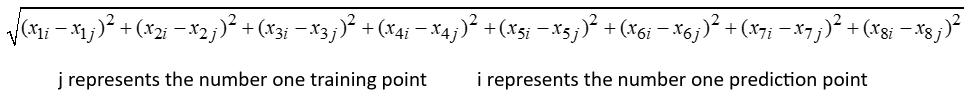

Since there are 8 independent variables in the data we are working with, so the 8 independent variables from prediction point 1 are subtracted from the 8 independent variables from practice point 1 and reach the power of 2 and are taken to the root.

You can see the architecture of this network.

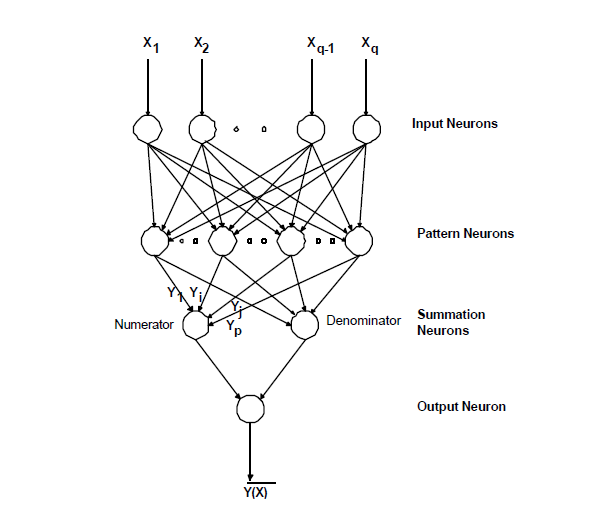

The network architecture consists of 4 layers. Input layer, pattern layer, summation layer and output layer. The input layer is the same training points that are used to calculate the prediction point. Using the above formula, the pattern layer obtains the distance between the variables to calculate the weight y of each training point to participate in the calculation of the y predictor point.

The sum layer itself consists of two parts: the face and the denominator of the fraction. The fraction form consists of the sum of the y multiplication of each training point by its related weight, the weight of which is obtained from the following relation.

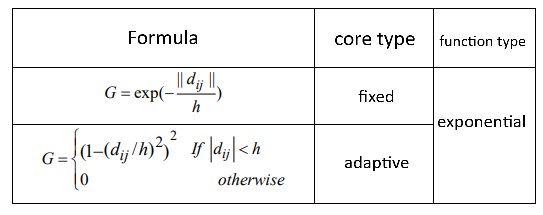

h
in above relationships, is a characteristically bandwidth.

The denominator of the fraction includes the sum of the weights calculated from the previous step.

The output layer consists of calculating y of the prediction point, which is possible by dividing the numerator and the denominator of the fraction obtained from the previous step.

In this method, we have only one parameter, which is the characteristically bandwidth, which we obtain by using the cross-validation method and testing different values.

Among the advantages of this method, we can mention the following
High speed of implementation of this method
Unlike feed forward Neural Networks
It always converges to the lowest global minimum and is never placed in the local minimum.

Let's look at an example.

input 2 4 6 8
output 3 5 7 9
  
What will be the output of 5??

Step 1
Calculate distances d1 = (5-2)^2 = 9 , d2= (5-4)^2 = 1, d3 =(5-6)^2=1, d4 = (5-8)^2 = 9.

Step 2
Calculate weights using the above formula for fixed kernel:   e-(d ∕ h)
Lets say h = 1.
so weights are, 
w1 =  0.0001
w2 =  0.3678
w3=   0.3678
w4=   0.0001

Step 3

Summation of  w's  W = w1+w2+w3+w4 =  0.7358
So denominator is 0.7358.
Now numerator is  YW = w1*y1 + w2*y2+w3*y3+ w4*y4
                                    =0.0001*3+0.3678*5+0.3678*7+0.0001*9 
                                    = 4.4148
<br>
Step 4

So the output is: (Neumerator/Denominator )

output = YW/W = 4.4148/0.7358 = 5.9999

So predicted output is 5.9999.

This method is based on the theory of nonlinear regression and if there is a nonlinear relationship between the observations, it will be able to model it. Using this model, a linear or nonlinear regression level of independent and dependent variables can be formed.

Now let's train the fixed-core general neural network regression method.

In [20]:
predictions_of_fixed_grnn_for_train=[]
bandwidth_for_fixed_grnn=0.06
for k in range(0,len(x_train)):
    current_coords=[x_coord_train[k][0],y_coord_train[k][0]]
    current_time=time_train[k][0]
    train_x_of_cv=np.asarray(x_train[0:k].tolist()+x_train[k+1::].tolist())
    train_y_of_cv=np.asarray(y_train[0:k].tolist()+y_train[k+1::].tolist())
    train_xcoords_of_cv=np.asarray(x_coord_train[0:k].tolist()+x_coord_train[k+1::].tolist())
    train_ycoords_of_cv=np.asarray(y_coord_train[0:k].tolist()+y_coord_train[k+1::].tolist())
    train_times_of_cv=np.asarray(time_train[0:k].tolist()+time_train[k+1::].tolist())
    n = len(train_x_of_cv)
    weights=[]
    for i in range(0,n):
        dis_feature=math.sqrt(sum((x_train[k]-train_x_of_cv[i])**2))
        weight_feature=np.exp((-1) * (dis_feature/bandwidth_for_fixed_grnn))
        weights.append(weight_feature)
    numerator=0
    denominator=0
    for j in range(0,len(weights)):
        numerator+=weights[j]*train_y_of_cv[j][0]
        denominator+=weights[j]
    predictions_of_fixed_grnn_for_train.append(numerator/denominator)

print('r2 score fixed grnn for train',r2_score(y_train, predictions_of_fixed_grnn_for_train))

r2 score fixed grnn for train 0.689003888254891


Let's evaluate the fixed-core generic neural network regression method.

In [36]:
predictions_of_fixed_grnn_for_test=[]
for i in range(0,len(x_test)):
    current_test=x_test[i]
    informations=[]
    for j in range(0,len(x_train)):
        dis_features=math.sqrt(sum((x_test[i]-x_train[j])**2))
        informations.append([dis_features,y_train[j]])
    weights=[]
    for k in range(0,len(informations)):
        weight_features=np.exp(-1 * (informations[k][0]/bandwidth_for_fixed_grnn))
        weights.append(weight_features)
    numerator=0
    denominator=0
    for l in range(0,len(informations)):
        numerator+=weights[l]*informations[l][1]
        denominator+=weights[l]
    predictions_of_fixed_grnn_for_test.append(numerator/denominator)

print('r2 score fixed grnn for test',r2_score(y_test, predictions_of_fixed_grnn_for_test))

r2 score fixed grnn for test 0.7288006227365025


Now we will train the regression method of the general neural network with the adaptive core.

In [48]:
predictions_of_adaptive_grnn_for_train=[]
n_neighbours_of_adaptive_grnn=10
for k in range(0,len(x_train)):
    train_x_of_cv=np.asarray(x_train[0:k].tolist()+x_train[k+1::].tolist())
    train_y_of_cv=np.asarray(y_train[0:k].tolist()+y_train[k+1::].tolist())
    n = len(train_x_of_cv)
    informations=[]
    for i in range(0,n):
        dis_feature=math.sqrt(sum((x_train[k]-train_x_of_cv[i])**2))
        informations.append([dis_feature,train_y_of_cv[i][0]])
    sorted_dis_features=[el[0] for el in informations]
    sorted_dis_features.sort()
    neighbours_features=sorted_dis_features[0:n_neighbours_of_adaptive_grnn]
    bandwidth=neighbours_features[-1]
    weights=[]
    for j in range(0,n):
        if informations[j][0]<=bandwidth:
            weight_feature=(1-(informations[j][0]/bandwidth)**2)**2
        else:
            weight_feature=0
        weights.append(weight_feature)
    numerator=0
    denominator=0
    for l in range(0,len(weights)):
        numerator+=weights[l]*informations[l][1]
        denominator+=weights[l]
    predictions_of_adaptive_grnn_for_train.append(numerator/denominator)

print('r2 score adaptive grnn for train',r2_score(y_train, predictions_of_adaptive_grnn_for_train))

r2 score adaptive grnn for train 0.6949456828189112


Now we will evaluate the regression method of the general neural network with the adaptive core.

In [38]:
predictions_of_adaptive_grnn_for_test=[]
for i in range(0,len(x_test)):
    current_test=x_test[i]
    informations=[]
    for j in range(0,len(x_train)):
        dis_features=math.sqrt(sum((x_test[i]-x_train[j])**2))
        informations.append([dis_features,y_train[j]])
    sorted_dis_features=[el[0] for el in informations]
    sorted_dis_features.sort()
    neighbours_features=sorted_dis_features[0:n_neighbours_of_adaptive_grnn]
    bandwidth=neighbours_features[-1]
    weights=[]
    for k in range(0,len(informations)):
        if informations[k][0]<= bandwidth:
            weight_features=(1-(informations[k][0]/bandwidth)**2)**2
        else:
            weight_features=0
        weights.append(weight_features)
    numerator=0
    denominator=0
    for l in range(0,len(informations)):
        numerator+=weights[l]*informations[l][1]
        denominator+=weights[l]
    predictions_of_adaptive_grnn_for_test.append(numerator/denominator)

print('r2 score adaptive grnn for test',r2_score(y_test, predictions_of_adaptive_grnn_for_test))

r2 score adaptive grnn for test 0.7249448704519762


In 2020, Pai and Wang modeled housing prices in Taichung City using the General Regression Neural Network method. In this modeling, they used the geographical coordinates of the centers of each property as an independent variable in estimating the price of housing. In order to be able to model the spatial heterogeneity in housing price observations, it is necessary to use the geographical coordinates of parcel centers in the transition function and calculate the geographical distance between the training point and the prediction point in this function. Thus, the closer the geographical distance of the training point to the prediction point, the greater the effect on the value of y of the prediction point. Thus, the weight used in the generalized regression neural network model in each of the fixed and adaptive cores including two spatial and characteristic components that are shown in the table below.

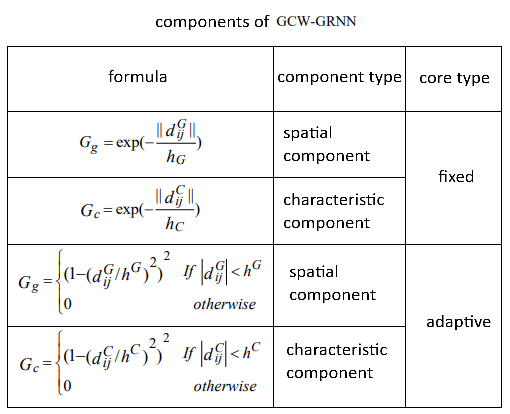

In these relationships, dG and dC are the geographical distance and characteristic distance between the training point i and the prediction point j, hG is the spatial bandwidth, and finally hC is the characteristic bandwidth. In this case, the transition function used in the GCW-GRNN model introduced and developed in this study in each of the fixed and adaptive core is obtained from the product of two spatial and characteristic components.

Now we will train the  geographically and characteristically weighted generalized neural network regression with a fixed core and Euclidean distance.

In [39]:
predictions_of_euclidean_fixed_gcw_grnn_for_train=[]
geographic_bandwidth_for_euclidean_fixed_gcw_grnn=1500
for k in range(0,len(x_train)):
    current_coords=[x_coord_train[k][0],y_coord_train[k][0]]
    train_x_of_cv=np.asarray(x_train[0:k].tolist()+x_train[k+1::].tolist())
    train_y_of_cv=np.asarray(y_train[0:k].tolist()+y_train[k+1::].tolist())
    train_xcoords_of_cv=np.asarray(x_coord_train[0:k].tolist()+x_coord_train[k+1::].tolist())
    train_ycoords_of_cv=np.asarray(y_coord_train[0:k].tolist()+y_coord_train[k+1::].tolist())
    n = len(train_x_of_cv)
    weights=[]
    for i in range(0,n):
        dis_feature=math.sqrt(sum((x_train[k]-train_x_of_cv[i])**2))
        weight_feature=np.exp((-1) * (dis_feature/bandwidth_for_fixed_grnn))
        diff_geographic=[current_coords[0]-train_xcoords_of_cv[i][0],current_coords[1]-train_ycoords_of_cv[i][0]]
        dis_geographic=math.sqrt(diff_geographic[0]**2+diff_geographic[1]**2)
        weight_geographic=math.exp((-1)*(dis_geographic/geographic_bandwidth_for_euclidean_fixed_gcw_grnn))
        weight=weight_feature*weight_geographic
        weights.append(weight)
    numerator=0
    denominator=0
    for l in range(0,len(weights)):
        numerator+=weights[l]*train_y_of_cv[l][0]
        denominator+=weights[l]
    predictions_of_euclidean_fixed_gcw_grnn_for_train.append(numerator/denominator)

print('r2 score fixed gcw-grnn for train',r2_score(y_train, predictions_of_euclidean_fixed_gcw_grnn_for_train))

r2 score fixed gcw-grnn for train 0.7024847539812724


Now, we evaluate the  geographically and characteristically weighted generalized neural network regression with a fixed core and Euclidean distance.

In [40]:
predictions_of_euclidean_fixed_gcw_grnn_for_test=[]
for i in range(0,len(x_test)):
    current_test=x_test[i]
    informations=[]
    for j in range(0,len(x_train)):
        dis_features=math.sqrt(sum((x_test[i]-x_train[j])**2))
        dis_coordinates=math.sqrt((x_coord_test[i][0]-x_coord_train[j][0])**2+\
                                  (y_coord_test[i][0]-y_coord_train[j][0])**2)
        informations.append([dis_features,dis_coordinates,y_train[j]])
    weights=[]
    for k in range(0,len(informations)):
        weight_features=np.exp(-1 * (informations[k][0]/bandwidth_for_fixed_grnn))
        weight_coordinates=np.exp(-1 * (informations[k][1]/geographic_bandwidth_for_euclidean_fixed_gcw_grnn))
        weights.append(weight_features*weight_coordinates)
    numerator=0
    denominator=0
    for l in range(0,len(informations)):
        numerator+=weights[l]*informations[l][2]
        denominator+=weights[l]
    predictions_of_euclidean_fixed_gcw_grnn_for_test.append(numerator/denominator)

print('r2 score fixed gcw_grnn for test',r2_score(y_test, predictions_of_euclidean_fixed_gcw_grnn_for_test))

r2 score fixed gcw_grnn for test 0.7646487930385749


In the problems of housing price modeling, in addition to spatial heterogeneity, there is also temporal heterogeneity, and it is necessary to consider the time component between the training point and the forecast point in the transition function. Therefore, it is necessary to consider the two dimensions of space and time simultaneously. The two dimensions of space and time, along with the characteristic dimension of the transition function used in the spatiotemporal Weighted Generalized Regression Neural Network Model.

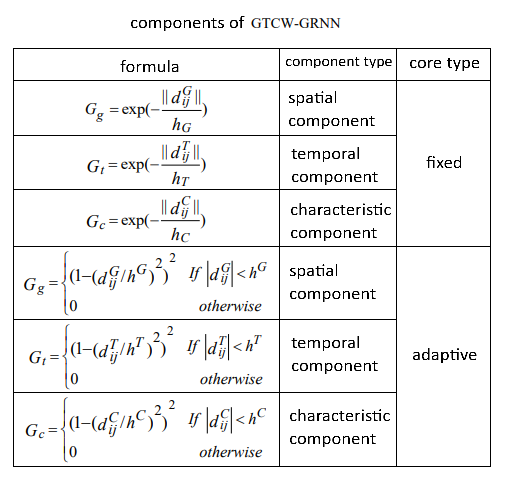

In these relationships, dT represents the time interval between the training point and the prediction point and the time bandwidth hT. In this case, the transition function used in the GTCW-GRNN model is obtained from the product of three spatial, temporal, and characteristical components.

Now we will train the  geographically, temporally and characteristically weighted generalized neural network with a fixed core and Euclidean distance.

In [41]:
predictions_of_euclidean_fixed_gtcw_grnn_for_train=[]
time_bandwidth_for_euclidean_fixed_gtcw_grnn=200
for k in range(0,len(x_train)):
    current_coords=[x_coord_train[k][0],y_coord_train[k][0]]
    current_time=time_train[k]
    train_x_of_cv=np.asarray(x_train[0:k].tolist()+x_train[k+1::].tolist())
    train_y_of_cv=np.asarray(y_train[0:k].tolist()+y_train[k+1::].tolist())
    train_xcoords_of_cv=np.asarray(x_coord_train[0:k].tolist()+x_coord_train[k+1::].tolist())
    train_ycoords_of_cv=np.asarray(y_coord_train[0:k].tolist()+y_coord_train[k+1::].tolist())
    train_times_of_cv=np.asarray(time_train[0:k].tolist()+time_train[k+1::].tolist())
    n = len(train_x_of_cv)
    weights=[]
    for i in range(0,n):
        dis_feature=math.sqrt(sum((x_train[k]-train_x_of_cv[i])**2))
        weight_feature=np.exp((-1) * (dis_feature/bandwidth_for_fixed_grnn))
        diff_geographic=[current_coords[0]-train_xcoords_of_cv[i][0],current_coords[1]-train_ycoords_of_cv[i][0]]
        dis_geographic=math.sqrt(diff_geographic[0]**2+diff_geographic[1]**2)
        weight_geographic=math.exp((-1)*(dis_geographic/geographic_bandwidth_for_euclidean_fixed_gcw_grnn))
        dis_time=np.abs(current_time-train_times_of_cv[i])
        weight_time=math.exp((-1)*(dis_time/time_bandwidth_for_euclidean_fixed_gtcw_grnn))
        weight=weight_feature*weight_geographic*weight_time
        weights.append(weight)
    numerator=0
    denominator=0
    for l in range(0,len(weights)):
        numerator+=weights[l]*train_y_of_cv[l][0]
        denominator+=weights[l]
    predictions_of_euclidean_fixed_gtcw_grnn_for_train.append(numerator/denominator)

print('r2 score fixed gtcw_grnn for train',r2_score(y_train, predictions_of_euclidean_fixed_gtcw_grnn_for_train))

r2 score fixed gtcw_grnn for train 0.718195711908335


Now we will train the  geographically, temporally and characteristically weighted generalized neural network with a fixed core and Euclidean distance.

In [42]:
predictions_of_euclidean_fixed_gtcw_grnn_for_test=[]
for i in range(0,len(x_test)):
    current_test=x_test[i]
    informations=[]
    for j in range(0,len(x_train)):
        dis_features=math.sqrt(sum((x_test[i]-x_train[j])**2))
        dis_coordinates=math.sqrt((x_coord_test[i][0]-x_coord_train[j][0])**2+\
                                  (y_coord_test[i][0]-y_coord_train[j][0])**2)
        dis_times=math.sqrt((time_test[i][0]-time_train[j][0])**2)
        informations.append([dis_features,dis_coordinates,dis_times,y_train[j]])
    weights=[]
    for k in range(0,len(informations)):
        weight_features=np.exp(-1 * (informations[k][0]/bandwidth_for_fixed_grnn))
        weight_coordinates=np.exp(-1 * (informations[k][1]/geographic_bandwidth_for_euclidean_fixed_gcw_grnn))
        weight_times=np.exp(-1 * (informations[k][2]/time_bandwidth_for_euclidean_fixed_gtcw_grnn))
        weights.append(weight_features*weight_coordinates*weight_times)
    numerator=0
    denominator=0
    for l in range(0,len(informations)):
        numerator+=weights[l]*informations[l][3]
        denominator+=weights[l]
    predictions_of_euclidean_fixed_gtcw_grnn_for_test.append(numerator/denominator)

print('r2 score euclidean fixed gtcw_grnn for test',r2_score(y_test, predictions_of_euclidean_fixed_gtcw_grnn_for_test))

r2 score euclidean fixed gtcw_grnn for test 0.7638871097111397


Now we will train the  geographically, temporally and characteristically weighted generalized neural network with an adaptive core and Euclidean distance.

In [21]:
predictions_of_euclidean_adaptive_gcw_grnn_for_train=[]
n_neighbours_of_euclidean_adaptive_gcw_grnn_for_geographic=699
for k in range(0,len(x_train)):
    current_coords=[x_coord_train[k][0],y_coord_train[k][0]]
    current_time=time_train[k]
    train_x_of_cv=np.asarray(x_train[0:k].tolist()+x_train[k+1::].tolist())
    train_y_of_cv=np.asarray(y_train[0:k].tolist()+y_train[k+1::].tolist())
    train_xcoords_of_cv=np.asarray(x_coord_train[0:k].tolist()+x_coord_train[k+1::].tolist())
    train_ycoords_of_cv=np.asarray(y_coord_train[0:k].tolist()+y_coord_train[k+1::].tolist())
    train_times_of_cv=np.asarray(time_train[0:k].tolist()+time_train[k+1::].tolist())
    n = len(train_x_of_cv)
    informations=[]
    for i in range(0,n):
        dis_feature=math.sqrt(sum((x_train[k]-train_x_of_cv[i])**2))
        diff_geographic=[current_coords[0]-train_xcoords_of_cv[i][0],current_coords[1]-train_ycoords_of_cv[i][0]]
        dis_geographic=math.sqrt(diff_geographic[0]**2+diff_geographic[1]**2)
        informations.append([dis_feature,dis_geographic,train_y_of_cv[i][0]])
    sorted_dis_features=[el[0] for el in informations]
    sorted_dis_features.sort()
    neighbours_features=sorted_dis_features[0:n_neighbours_of_adaptive_grnn]
    bandwidth=neighbours_features[-1]
    sorted_dis_coordinates=[el[1] for el in informations]
    sorted_dis_coordinates.sort()
    neighbours_coordinates=sorted_dis_coordinates[0:n_neighbours_of_euclidean_adaptive_gcw_grnn_for_geographic]
    geographic_bandwidth=neighbours_coordinates[-1]
    weights=[]
    for j in range(0,len(informations)):
        if informations[j][0]<= bandwidth:
            weight_feature=(1-(informations[j][0]/bandwidth)**2)**2
        else:
            weight_feature=0
        if informations[j][1]<= geographic_bandwidth:
            weight_geographic=(1-(informations[j][1]/geographic_bandwidth)**2)**2
        else:
            weight_geographic=0
        weight=weight_feature*weight_geographic
        weights.append(weight)
    numerator=0
    denominator=0
    for l in range(0,len(informations)):
        numerator+=weights[l]*informations[l][2]
        denominator+=weights[l]
    predictions_of_euclidean_adaptive_gcw_grnn_for_train.append(numerator/denominator)

print('r2 score euclidean adaptive gcw_grnn for train',r2_score(y_train, predictions_of_euclidean_adaptive_gcw_grnn_for_train))

r2 score euclidean adaptive gcw_grnn for train 0.6856394351216444


Now, we evaluate the  geographically, temporally and characteristically weighted generalized neural network with an adaptive core and Euclidean distance.

In [44]:
predictions_of_euclidean_adaptive_gcw_grnn_for_test=[]
for i in range(0,len(x_test)):
    current_test=x_test[i]
    informations=[]
    for j in range(0,len(x_train)):
        dis_features=math.sqrt(sum((x_test[i]-x_train[j])**2))
        dis_coordinates=math.sqrt((x_coord_test[i][0]-x_coord_train[j][0])**2+\
                                  (y_coord_test[i][0]-y_coord_train[j][0])**2)
        informations.append([dis_features,dis_coordinates,y_train[j]])
    sorted_dis_features=[el[0] for el in informations]
    sorted_dis_features.sort()
    neighbours_features=sorted_dis_features[0:n_neighbours_of_adaptive_grnn]
    bandwidth=neighbours_features[-1]
    sorted_dis_coordinates=[el[1] for el in informations]
    sorted_dis_coordinates.sort()
    neighbours_coordinates=sorted_dis_coordinates[0:n_neighbours_of_euclidean_adaptive_gcw_grnn_for_geographic]
    geographic_bandwidth=neighbours_coordinates[-1]
    weights=[]
    for k in range(0,len(informations)):
        if informations[k][0]<= bandwidth:
            weight_features=(1-(informations[k][0]/bandwidth)**2)**2
        else:
            weight_features=0
        if informations[k][1]<= geographic_bandwidth:
            weight_coordinates=(1-(informations[k][1]/geographic_bandwidth)**2)**2
        else:
            weight_coordinates=0
        weights.append(weight_features*weight_coordinates)
    numerator=0
    denominator=0
    for l in range(0,len(informations)):
        numerator+=weights[l]*informations[l][2]
        denominator+=weights[l]
    predictions_of_euclidean_adaptive_gcw_grnn_for_test.append(numerator/denominator)

print('r2 score euclidean adaptive gcw_grnn for test',r2_score(y_test, predictions_of_euclidean_adaptive_gcw_grnn_for_test))

r2 score euclidean adaptive gcw_grnn for test 0.7220536326592734


Now, we will train the  geographically, temporally and characteristically weighted generalized neural network with an adaptive core and Euclidean distance.

In [45]:
predictions_of_euclidean_adaptive_gtcw_grnn_for_train=[]
n_neighbours_of_euclidean_adaptive_gtcw_grnn_for_time=400
for k in range(0,len(x_train)):
    current_coords=[x_coord_train[k][0],y_coord_train[k][0]]
    current_time=time_train[k]
    train_x_of_cv=np.asarray(x_train[0:k].tolist()+x_train[k+1::].tolist())
    train_y_of_cv=np.asarray(y_train[0:k].tolist()+y_train[k+1::].tolist())
    train_xcoords_of_cv=np.asarray(x_coord_train[0:k].tolist()+x_coord_train[k+1::].tolist())
    train_ycoords_of_cv=np.asarray(y_coord_train[0:k].tolist()+y_coord_train[k+1::].tolist())
    train_times_of_cv=np.asarray(time_train[0:k].tolist()+time_train[k+1::].tolist())
    n = len(train_x_of_cv)
    informations=[]
    for i in range(0,n):
        dis_feature=math.sqrt(sum((x_train[k]-train_x_of_cv[i])**2))
        diff_geographic=[current_coords[0]-train_xcoords_of_cv[i][0],current_coords[1]-train_ycoords_of_cv[i][0]]
        dis_geographic=math.sqrt(diff_geographic[0]**2+diff_geographic[1]**2)
        dis_time=np.abs(current_time-train_times_of_cv[i])[0]
        informations.append([dis_feature,dis_geographic,dis_time,train_y_of_cv[i][0]])
    sorted_dis_features=[el[0] for el in informations]
    sorted_dis_features.sort()
    neighbours_features=sorted_dis_features[0:n_neighbours_of_adaptive_grnn]
    bandwidth=neighbours_features[-1]
    sorted_dis_coordinates=[el[1] for el in informations]
    sorted_dis_coordinates.sort()
    neighbours_coordinates=sorted_dis_coordinates[0:n_neighbours_of_euclidean_adaptive_gcw_grnn_for_geographic]
    geographic_bandwidth=neighbours_coordinates[-1]
    sorted_dis_times=[el[2] for el in informations]
    sorted_dis_times=list(set(sorted_dis_times))
    sorted_dis_times=sorted(sorted_dis_times)
    neighbours_times=sorted_dis_times[0:n_neighbours_of_euclidean_adaptive_gtcw_grnn_for_time]
    time_bandwidth=neighbours_times[-1]
    weights=[]
    for j in range(0,len(informations)):
        if informations[j][0]<= bandwidth:
            weight_feature=(1-(informations[j][0]/bandwidth)**2)**2
        else:
            weight_feature=0
        if informations[j][1]<= geographic_bandwidth:
            weight_geographic=(1-(informations[j][1]/geographic_bandwidth)**2)**2
        else:
            weight_geographic=0
        if informations[j][2]<= time_bandwidth:
            weight_time=(1-(informations[j][2]/time_bandwidth)**2)**2
        else:
            weight_time=0
        weight=weight_feature*weight_geographic*weight_time
        weights.append(weight)
    numerator=0
    denominator=0
    for l in range(0,len(informations)):
        numerator+=weights[l]*informations[l][3]
        denominator+=weights[l]
    predictions_of_euclidean_adaptive_gtcw_grnn_for_train.append(numerator/denominator)

print('r2 score euclidean adaptive gtcw_grnn for train',r2_score(y_train,\
                                                                 predictions_of_euclidean_adaptive_gtcw_grnn_for_train))

r2 score euclidean adaptive gtcw_grnn for train 0.6968556342571498


Now, we evaluate the geographically, temporally and characteristically weighted generalized neural network with an adaptive core and Euclidean distance.

In [46]:
predictions_of_euclidean_adaptive_gtcw_grnn_for_test=[]
for i in range(0,len(x_test)):
    current_test=x_test[i]
    informations=[]
    for j in range(0,len(x_train)):
        dis_features=math.sqrt(sum((x_test[i]-x_train[j])**2))
        dis_coordinates=math.sqrt((x_coord_test[i][0]-x_coord_train[j][0])**2+\
                                  (y_coord_test[i][0]-y_coord_train[j][0])**2)
        dis_times=math.sqrt((time_test[i]-time_train[j])**2)
        informations.append([dis_features,dis_coordinates,dis_times,y_train[j]])
    sorted_dis_features=[el[0] for el in informations]
    sorted_dis_features.sort()
    neighbours_features=sorted_dis_features[0:n_neighbours_of_adaptive_grnn]
    bandwidth=neighbours_features[-1]
    sorted_dis_coordinates=[el[1] for el in informations]
    sorted_dis_coordinates.sort()
    neighbours_coordinates=sorted_dis_coordinates[0:n_neighbours_of_euclidean_adaptive_gcw_grnn_for_geographic]
    geographic_bandwidth=neighbours_coordinates[-1]
    sorted_dis_times=[el[2] for el in informations]
    sorted_dis_times=list(set(sorted_dis_times))
    sorted_dis_times=sorted(sorted_dis_times)
    neighbours_times=sorted_dis_times[0:n_neighbours_of_euclidean_adaptive_gtcw_grnn_for_time]
    time_bandwidth=neighbours_times[-1]
    weights=[]
    for k in range(0,len(informations)):
        if informations[k][0]<= bandwidth:
            weight_features=(1-(informations[k][0]/bandwidth)**2)**2
        else:
            weight_features=0
        if informations[k][1]<= geographic_bandwidth:
            weight_coordinates=(1-(informations[k][1]/geographic_bandwidth)**2)**2
        else:
            weight_coordinates=0
        if informations[k][2]<= time_bandwidth:
            weight_times=(1-(informations[k][2]/time_bandwidth)**2)**2
        else:
            weight_times=0
        weights.append(weight_features*weight_coordinates*weight_times)
    numerator=0
    denominator=0
    for l in range(0,len(informations)):
        numerator+=weights[l]*informations[l][3]
        denominator+=weights[l]
    predictions_of_euclidean_adaptive_gtcw_grnn_for_test.append(numerator/denominator)

print('r2 score euclidean adaptive gtcw_grnn for test',r2_score(y_test, predictions_of_euclidean_adaptive_gtcw_grnn_for_test))

r2 score euclidean adaptive gtcw_grnn for test 0.7124219398125772


Now we will train the geographically, temporally and characteristically weighted generalized neural network with a fixed core and travel distance.

In [33]:
predictions_of_travel_fixed_gcw_grnn_for_train=[]
geographic_bandwidth_for_travel_fixed_gcw_grnn=3500
tmp_df=df_train_travel_distances.loc[:,~df_train_travel_distances.columns.duplicated()].copy()
for k in range(0,len(x_train)):
    current_coords=[lat_train[k][0],lon_train[k][0]]
    current_time=time_train[k]
    train_x_of_cv=np.asarray(x_train[0:k].tolist()+x_train[k+1::].tolist())
    train_y_of_cv=np.asarray(y_train[0:k].tolist()+y_train[k+1::].tolist())
    train_lon_of_cv=np.asarray(lon_train[0:k].tolist()+lon_train[k+1::].tolist())
    train_lat_of_cv=np.asarray(lat_train[0:k].tolist()+lat_train[k+1::].tolist())
    n = len(train_x_of_cv)
    weights=[]
    for i in range(0,n):
        st_1=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
        nd_2=str(round(train_lat_of_cv[i][0],8))+','+str(round(train_lon_of_cv[i][0],8))
        our_travel_distance=tmp_df[st_1][nd_2]
        dis_geographic=our_travel_distance
        if type(dis_geographic)!=np.float64:
            dis_geographic=dis_geographic.values.tolist()[0]
        weight_geographic=math.exp((-1)*(dis_geographic/geographic_bandwidth_for_travel_fixed_gcw_grnn))
        dis_feature=math.sqrt(sum((x_train[k]-train_x_of_cv[i])**2))
        weight_feature=np.exp((-1) * (dis_feature/bandwidth_for_fixed_grnn))
        weight=weight_feature*weight_geographic
        weights.append(weight)
    numerator=0
    denominator=0
    for l in range(0,len(weights)):
        numerator+=weights[l]*train_y_of_cv[l][0]
        denominator+=weights[l]
    predictions_of_travel_fixed_gcw_grnn_for_train.append(numerator/denominator)

print('r2 score travel fixed gcw_grnn',r2_score(y_train, predictions_of_travel_fixed_gcw_grnn_for_train))

r2 score travel fixed gcw_grnn 0.7077352784001383


Now, we evaluate the geographically, temporally and characteristically weighted generalized neural network with a fixed core and travel distance.

In [35]:
predictions_of_travel_fixed_gcw_grnn_for_test=[]
tmp_df=df_test_travel_distances.loc[:,~df_test_travel_distances.columns.duplicated()].copy()
for i in range(0,len(x_test)):
    current_test=x_test[i]
    current_coords=[lat_test[i][0],lon_test[i][0]]
    informations=[]
    for j in range(0,len(x_train)):
        dis_features=math.sqrt(sum((x_test[i]-x_train[j])**2))
        st_1=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
        nd_2=str(round(lat_train[j][0],8))+','+str(round(lon_train[j][0],8))
        try:
            our_travel_distance=tmp_df[st_1][nd_2]
        except:
            our_travel_distance=tmp_df[nd_2][st_1]
        dis_coordinates=our_travel_distance
        informations.append([dis_features,dis_coordinates,y_train[j]])
    weights=[]
    for k in range(0,len(informations)):
        weight_features=np.exp(-1 * (informations[k][0]/bandwidth_for_fixed_grnn))
        weight_coordinates=np.exp(-1 * (informations[k][1]/geographic_bandwidth_for_travel_fixed_gcw_grnn))
        weights.append(weight_features*weight_coordinates)
    numerator=0
    denominator=0
    for l in range(0,len(informations)):
        numerator+=weights[l]*informations[l][2]
        denominator+=weights[l]
    predictions_of_travel_fixed_gcw_grnn_for_test.append(numerator/denominator)

print('r2 score travel fixed gcw_grnn for test',r2_score(y_test, predictions_of_travel_fixed_gcw_grnn_for_test))

r2 score travel fixed gcw_grnn for test 0.7538705764154074


Now we will train the geographically, temporally and characteristically weighted generalized neural network with a fixed core and travel distance.

In [49]:
predictions_of_travel_fixed_gtcw_grnn_for_train=[]
time_bandwidth_for_travel_fixed_gtcw_grnn=200
tmp_df=df_train_travel_distances.loc[:,~df_train_travel_distances.columns.duplicated()].copy()
for k in range(0,len(x_train)):
    current_coords=[lat_train[k][0],lon_train[k][0]]
    current_time=time_train[k]
    train_x_of_cv=np.asarray(x_train[0:k].tolist()+x_train[k+1::].tolist())
    train_y_of_cv=np.asarray(y_train[0:k].tolist()+y_train[k+1::].tolist())
    train_lon_of_cv=np.asarray(lon_train[0:k].tolist()+lon_train[k+1::].tolist())
    train_lat_of_cv=np.asarray(lat_train[0:k].tolist()+lat_train[k+1::].tolist())
    train_times_of_cv=np.asarray(time_train[0:k].tolist()+time_train[k+1::].tolist())
    n = len(train_x_of_cv)
    weights=[]
    for i in range(0,n):
        st_1=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
        nd_2=str(round(train_lat_of_cv[i][0],8))+','+str(round(train_lon_of_cv[i][0],8))
        our_travel_distance=tmp_df[st_1][nd_2]
        dis_geographic=our_travel_distance
        if type(dis_geographic)!=np.float64:
            dis_geographic=dis_geographic.values.tolist()[0]
        weight_geographic=math.exp((-1)*(dis_geographic/geographic_bandwidth_for_travel_fixed_gcw_grnn))
        dis_time=np.abs(current_time-train_times_of_cv[i])
        weight_time=math.exp((-1)*(dis_time/time_bandwidth_for_travel_fixed_gtcw_grnn))
        dis_feature=math.sqrt(sum((x_train[k]-train_x_of_cv[i])**2))
        weight_feature=np.exp((-1) * (dis_feature/bandwidth_for_fixed_grnn))
        weight=weight_feature*weight_geographic*weight_time
        weights.append(weight)
    numerator=0
    denominator=0
    for l in range(0,len(weights)):
        numerator+=weights[l]*train_y_of_cv[l][0]
        denominator+=weights[l]
    predictions_of_travel_fixed_gtcw_grnn_for_train.append(numerator/denominator)

print('r2 score travel fixed gtcw_grnn for train',r2_score(y_train, predictions_of_travel_fixed_gtcw_grnn_for_train))

r2 score travel fixed gtcw_grnn for train 0.7273352702423348


Now, we evaluate the geographically, temporally and characteristically weighted generalized neural network with a fixed core and travel distance.

In [51]:
predictions_of_travel_fixed_gtcw_grnn_for_test=[]
tmp_df=df_test_travel_distances.loc[:,~df_test_travel_distances.columns.duplicated()].copy()
for i in range(0,len(x_test)):
    current_test=x_test[i]
    current_coords=[lat_test[i][0],lon_test[i][0]]                                            
    informations=[]
    for j in range(0,len(x_train)):
        dis_features=math.sqrt(sum((x_test[i]-x_train[j])**2))
        st_1=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
        nd_2=str(round(lat_train[j][0],8))+','+str(round(lon_train[j][0],8))
        try:
            our_travel_distance=tmp_df[st_1][nd_2]
        except:
            our_travel_distance=tmp_df[nd_2][st_1]
        dis_coordinates=our_travel_distance
        dis_times=math.sqrt((time_test[i][0]-time_train[j][0])**2)
        informations.append([dis_features,dis_coordinates,dis_times,y_train[j]])
    weights=[]
    for k in range(0,len(informations)):
        weight_features=np.exp(-1 * (informations[k][0]/bandwidth_for_fixed_grnn))
        weight_coordinates=np.exp(-1 * (informations[k][1]/geographic_bandwidth_for_travel_fixed_gcw_grnn))
        weight_times=np.exp(-1 * (informations[k][2]/time_bandwidth_for_travel_fixed_gtcw_grnn))
        weights.append(weight_features*weight_coordinates*weight_times)
    numerator=0
    denominator=0
    for l in range(0,len(informations)):
        numerator+=weights[l]*informations[l][3]
        denominator+=weights[l]
    predictions_of_travel_fixed_gtcw_grnn_for_test.append(numerator/denominator)

print('r2 score travel fixed gtcw_grnn for test',r2_score(y_test, predictions_of_travel_fixed_gtcw_grnn_for_test))

r2 score travel fixed gtcw_grnn for test 0.7533689322423212


Now, we will train the geographically, temporally and characteristically weighted generalized neural network with an adaptive core and travel distance.

In [49]:
predictions_of_travel_adaptive_gcw_grnn_for_train=[]
n_neighbours_of_travel_adaptive_gcw_grnn_for_geographic=699
tmp_df=df_train_travel_distances.loc[:,~df_train_travel_distances.columns.duplicated()].copy()
for k in range(0,len(x_train)):
    current_coords=[lat_train[k][0],lon_train[k][0]]
    train_x_of_cv=np.asarray(x_train[0:k].tolist()+x_train[k+1::].tolist())
    train_y_of_cv=np.asarray(y_train[0:k].tolist()+y_train[k+1::].tolist())
    train_lon_of_cv=np.asarray(lon_train[0:k].tolist()+lon_train[k+1::].tolist())
    train_lat_of_cv=np.asarray(lat_train[0:k].tolist()+lat_train[k+1::].tolist())
    n = len(train_x_of_cv)
    informations=[]
    for i in range(0,n):
        st_1=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
        nd_2=str(round(train_lat_of_cv[i][0],8))+','+str(round(train_lon_of_cv[i][0],8))
        our_travel_distance=tmp_df[st_1][nd_2]
        dis_geographic=our_travel_distance
        if type(dis_geographic)!=np.float64:
            dis_geographic=dis_geographic.values.tolist()[0]
        dis_feature=math.sqrt(sum((x_train[k]-train_x_of_cv[i])**2))
        informations.append([dis_feature,dis_geographic,train_y_of_cv[i][0]])
    sorted_dis_features=[el[0] for el in informations]
    sorted_dis_features.sort()
    neighbours_features=sorted_dis_features[0:n_neighbours_of_adaptive_grnn]
    bandwidth=neighbours_features[-1]
    sorted_dis_coordinates=[el[1] for el in informations]
    sorted_dis_coordinates.sort()
    neighbours_coordinates=sorted_dis_coordinates[0:n_neighbours_of_travel_adaptive_gcw_grnn_for_geographic]
    geographic_bandwidth=neighbours_coordinates[-1]
    weights=[]
    for j in range(0,len(informations)):
        if informations[j][0]<= bandwidth:
            weight_feature=(1-(informations[j][0]/bandwidth)**2)**2
        else:
            weight_feature=0
        if informations[j][1]<= geographic_bandwidth:
            weight_geographic=(1-(informations[j][1]/geographic_bandwidth)**2)**2
        else:
            weight_geographic=0
        weight=weight_feature*weight_geographic
        weights.append(weight)
    numerator=0
    denominator=0
    for l in range(0,len(informations)):
        numerator+=weights[l]*informations[l][2]
        denominator+=weights[l]
    predictions_of_travel_adaptive_gcw_grnn_for_train.append(numerator/denominator)

print('r2 score travel adaptive gcw_grnn for train',r2_score(y_train, predictions_of_travel_adaptive_gcw_grnn_for_train))

r2 score travel adaptive gcw_grnn for train 0.6894580130607885


Now, we evaluate the geographically, temporally and characteristically weighted generalized neural network with an adaptive core and travel distance.

In [27]:
predictions_of_travel_adaptive_gcw_grnn_for_test=[]
tmp_df=df_test_travel_distances.loc[:,~df_test_travel_distances.columns.duplicated()].copy()
for i in range(0,len(x_test)):
    current_test=x_test[i]
    current_coords=[lat_test[i][0],lon_test[i][0]]
    informations=[]
    for j in range(0,len(x_train)):
        dis_features=math.sqrt(sum((x_test[i]-x_train[j])**2))
        st_1=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
        nd_2=str(round(lat_train[j][0],8))+','+str(round(lon_train[j][0],8))
        try:
            our_travel_distance=tmp_df[st_1][nd_2]
        except:
            our_travel_distance=tmp_df[nd_2][st_1]
        dis_coordinates=our_travel_distance
        informations.append([dis_features,dis_coordinates,y_train[j]])
    sorted_dis_features=[el[0] for el in informations]
    sorted_dis_features.sort()
    neighbours_features=sorted_dis_features[0:n_neighbours_of_adaptive_grnn]
    bandwidth=neighbours_features[-1]
    sorted_dis_coordinates=[el[1] for el in informations]
    sorted_dis_coordinates.sort()
    neighbours_coordinates=sorted_dis_coordinates[0:n_neighbours_of_travel_adaptive_gcw_grnn_for_geographic]
    geographic_bandwidth=neighbours_coordinates[-1]
    weights=[]
    for k in range(0,len(informations)):
        if informations[k][0]<= bandwidth:
            weight_features=(1-(informations[k][0]/bandwidth)**2)**2
        else:
            weight_features=0
        if informations[k][1]<= geographic_bandwidth:
            weight_coordinates=(1-(informations[k][1]/geographic_bandwidth)**2)**2
        else:
            weight_coordinates=0
        weights.append(weight_features*weight_coordinates)
    numerator=0
    denominator=0
    for l in range(0,len(informations)):
        numerator+=weights[l]*informations[l][2]
        denominator+=weights[l]
    predictions_of_travel_adaptive_gcw_grnn_for_test.append(numerator/denominator)

print('r2 score travel adaptive gcw_grnn for test',r2_score(y_test, predictions_of_travel_adaptive_gcw_grnn_for_test))

r2 score travel adaptive gcw_grnn for test 0.7237485609693354


Now, we will train the geographically, temporally and characteristically weighted generalized neural network with an adaptive core and travel distance.

In [51]:
n_neighbours_of_travel_adaptive_gtcw_grnn_for_time=400
predictions_of_travel_adaptive_gtcw_grnn_for_train=[]
tmp_df=df_train_travel_distances.loc[:,~df_train_travel_distances.columns.duplicated()].copy()
for k in range(0,len(x_train)):
    current_coords=[lat_train[k][0],lon_train[k][0]]
    current_time=time_train[k][0]
    desired_index_time=str(current_time)
    current_time_distances=df_times_train.loc[desired_index_time].values.tolist()
    if len(current_time_distances)!=699:
        current_time_distances=list(set(df_times_train.loc[desired_index_time].values.tolist()[0]))
    elif len(current_time_distances)==699:
        current_time_distances=list(set(df_times_train.loc[desired_index_time].values.tolist()))
    current_time_distances.sort()
    neighbours_time=current_time_distances[1:n_neighbours_of_travel_adaptive_gtcw_grnn_for_time]
    time_bandwidth=neighbours_time[-1]
    train_x_of_cv=np.asarray(x_train[0:k].tolist()+x_train[k+1::].tolist())
    train_y_of_cv=np.asarray(y_train[0:k].tolist()+y_train[k+1::].tolist())
    train_lon_of_cv=np.asarray(lon_train[0:k].tolist()+lon_train[k+1::].tolist())
    train_lat_of_cv=np.asarray(lat_train[0:k].tolist()+lat_train[k+1::].tolist())
    current_time=time_train[k]
    train_times_of_cv=np.asarray(time_train[0:k].tolist()+time_train[k+1::].tolist())
    n = len(train_x_of_cv)
    informations=[]
    for i in range(0,n):
        st_1=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
        nd_2=str(round(train_lat_of_cv[i][0],8))+','+str(round(train_lon_of_cv[i][0],8))
        our_travel_distance=tmp_df[st_1][nd_2]
        dis_geographic=our_travel_distance
        if type(dis_geographic)!=np.float64:
            dis_geographic=dis_geographic.values.tolist()[0]
        dis_time=np.abs(current_time-train_times_of_cv[i])
        dis_feature=math.sqrt(sum((x_train[k]-train_x_of_cv[i])**2))
        informations.append([dis_feature,dis_geographic,dis_time,train_y_of_cv[i][0]])
    sorted_dis_features=[el[0] for el in informations]
    sorted_dis_features.sort()
    neighbours_features=sorted_dis_features[0:n_neighbours_of_adaptive_grnn]
    bandwidth=neighbours_features[-1]
    sorted_dis_coordinates=[el[1] for el in informations]
    sorted_dis_coordinates.sort()
    neighbours_coordinates=sorted_dis_coordinates[0:n_neighbours_of_travel_adaptive_gcw_grnn_for_geographic]
    geographic_bandwidth=neighbours_coordinates[-1]
    weights=[]
    for j in range(0,len(informations)):
        if informations[j][0]<= bandwidth:
            weight_feature=(1-(informations[j][0]/bandwidth)**2)**2
        else:
            weight_feature=0
        if informations[j][1]<= geographic_bandwidth:
            weight_geographic=(1-(informations[j][1]/geographic_bandwidth)**2)**2
        else:
            weight_geographic=0
        if informations[j][2]<=time_bandwidth:
            weight_time=(1-(informations[j][2]/time_bandwidth)**2)**2
        else:
            weight_time=0
        weight=weight_feature*weight_geographic*weight_time
        weights.append(weight)
    numerator=0
    denominator=0
    for l in range(0,len(informations)):
        numerator+=weights[l]*informations[l][3]
        denominator+=weights[l]
    predictions_of_travel_adaptive_gtcw_grnn_for_train.append(numerator/denominator)

print('r2 score travel adaptive gtcw_grnn for train',r2_score(y_train, predictions_of_travel_adaptive_gtcw_grnn_for_train))

r2 score travel adaptive gtcw_grnn for train 0.7008722535904316


Now, we evaluate the geographically, temporally and characteristically weighted generalized neural network with an adaptive core and travel distance.

In [52]:
predictions_of_travel_adaptive_gtcw_grnn_for_test=[]
tmp_df=df_test_travel_distances.loc[:,~df_test_travel_distances.columns.duplicated()].copy()
for i in range(0,len(x_test)):
    current_test=x_test[i]
    current_coords=[lat_test[i][0],lon_test[i][0]]
    current_time=time_test[i][0]
    desired_index_time=str(current_time)
    current_time_distances=df_times_test.loc[desired_index_time].values.tolist()
    if len(current_time_distances)!=699:
        current_time_distances=list(set(df_times_test.loc[desired_index_time].values.tolist()[0]))
    elif len(current_time_distances)==699:
        current_time_distances=list(set(df_times_test.loc[desired_index_time].values.tolist()))
    current_time_distances.sort()
    neighbours_time=current_time_distances[0:n_neighbours_of_travel_adaptive_gtcw_grnn_for_time]
    time_bandwidth=neighbours_time[-1]
    informations=[]
    for j in range(0,len(x_train)):
        dis_features=math.sqrt(sum((x_test[i]-x_train[j])**2))
        st_1=str(round(current_coords[0],8))+','+str(round(current_coords[1],8))
        nd_2=str(round(lat_train[j][0],8))+','+str(round(lon_train[j][0],8))
        try:
            our_travel_distance=tmp_df[st_1][nd_2]
        except:
            our_travel_distance=tmp_df[nd_2][st_1]
        dis_coordinates=our_travel_distance
        dis_times=math.sqrt((time_test[i]-time_train[j])**2)
        informations.append([dis_features,dis_coordinates,dis_times,y_train[j]])
    sorted_dis_features=[el[0] for el in informations]
    sorted_dis_features.sort()
    neighbours_features=sorted_dis_features[0:n_neighbours_of_adaptive_grnn]
    bandwidth=neighbours_features[-1]
    sorted_dis_coordinates=[el[1] for el in informations]
    sorted_dis_coordinates.sort()
    neighbours_coordinates=sorted_dis_coordinates[0:n_neighbours_of_travel_adaptive_gcw_grnn_for_geographic]
    geographic_bandwidth=neighbours_coordinates[-1]
    weights=[]
    for k in range(0,len(informations)):
        if informations[k][0]<= bandwidth:
            weight_features=(1-(informations[k][0]/bandwidth)**2)**2
        else:
            weight_features=0
        if informations[k][1]<= geographic_bandwidth:
            weight_coordinates=(1-(informations[k][1]/geographic_bandwidth)**2)**2
        else:
            weight_coordinates=0
        if informations[k][2]<=time_bandwidth:
            weight_time=(1-(informations[k][2]/time_bandwidth)**2)**2
        else:
            weight_time=0
        weights.append(weight_features*weight_coordinates*weight_time)
    numerator=0
    denominator=0
    for l in range(0,len(informations)):
        numerator+=weights[l]*informations[l][3]
        denominator+=weights[l]
    predictions_of_travel_adaptive_gtcw_grnn_for_test.append(numerator/denominator)

print('r2 score travel adaptive gtcw_grnn for test',r2_score(y_test, predictions_of_travel_adaptive_gtcw_grnn_for_test))

r2 score travel adaptive gtcw_grnn for test 0.7143382562590525
